# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer=separable_conv2d_batchnorm(input_layer, filters, strides=strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [11]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output = layers.concatenate([upsampled_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer1=separable_conv2d_batchnorm(output, filters, strides=1)
    output_layer2=separable_conv2d_batchnorm(output_layer1, filters, strides=1)
    output_layer=separable_conv2d_batchnorm(output_layer2, filters, strides=1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [12]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    fcn_1=encoder_block(inputs, filters=32, strides=2)
    fcn_2=encoder_block(fcn_1, filters=64, strides=2)
    fcn_3=encoder_block(fcn_2, filters=128, strides=2)
    fcn_4=encoder_block(fcn_3, filters=256, strides=2)
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    one_By_one = conv2d_batchnorm(fcn_4,filters=512,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    d1=decoder_block(one_By_one, fcn_3, filters=256)
    d2=decoder_block(d1, fcn_2, filters=128)
    d3=decoder_block(d2, fcn_1, filters=64)
    x =decoder_block(d3, inputs, filters=32)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [14]:
learning_rate = 0.001
batch_size = 64
num_epochs = 150
steps_per_epoch = 66
validation_steps = 25
workers = 20

Epoch 1/200
65/66 [============================>.] - ETA: 1s - loss: 0.7722

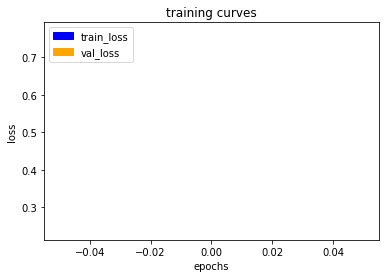

66/66 [==============================] - 125s - loss: 0.7640 - val_loss: 0.2401
Epoch 2/200
65/66 [============================>.] - ETA: 1s - loss: 0.1067

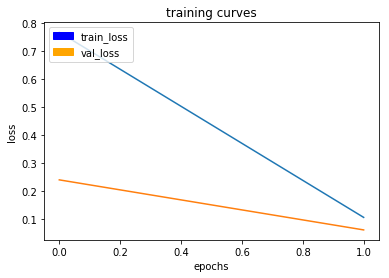

66/66 [==============================] - 118s - loss: 0.1059 - val_loss: 0.0615
Epoch 3/200
65/66 [============================>.] - ETA: 1s - loss: 0.0504

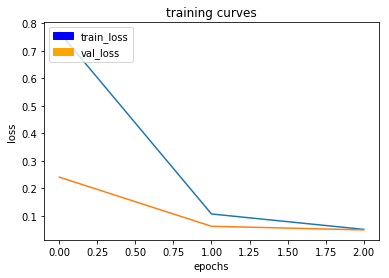

66/66 [==============================] - 118s - loss: 0.0502 - val_loss: 0.0482
Epoch 4/200
65/66 [============================>.] - ETA: 1s - loss: 0.0370

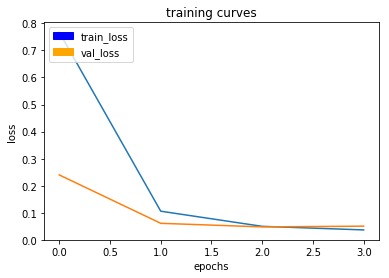

66/66 [==============================] - 119s - loss: 0.0370 - val_loss: 0.0509
Epoch 5/200
65/66 [============================>.] - ETA: 1s - loss: 0.0295

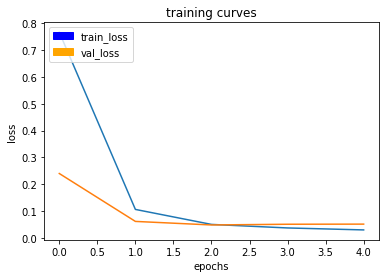

66/66 [==============================] - 119s - loss: 0.0297 - val_loss: 0.0514
Epoch 6/200
65/66 [============================>.] - ETA: 1s - loss: 0.0282

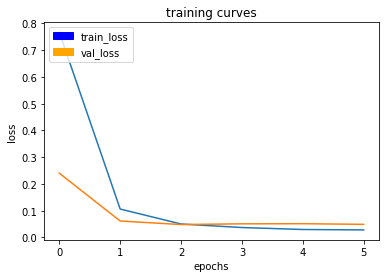

66/66 [==============================] - 118s - loss: 0.0283 - val_loss: 0.0490
Epoch 7/200
65/66 [============================>.] - ETA: 1s - loss: 0.0260

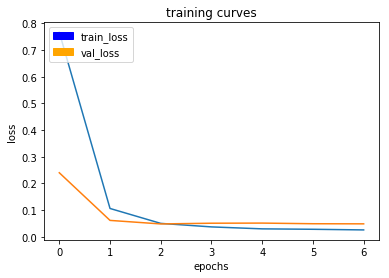

66/66 [==============================] - 120s - loss: 0.0258 - val_loss: 0.0486
Epoch 8/200
65/66 [============================>.] - ETA: 1s - loss: 0.0219

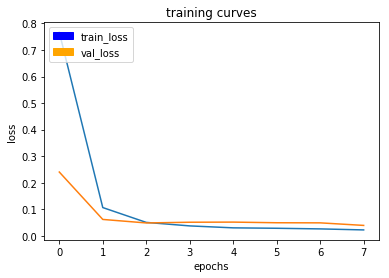

66/66 [==============================] - 119s - loss: 0.0220 - val_loss: 0.0390
Epoch 9/200
65/66 [============================>.] - ETA: 1s - loss: 0.0201

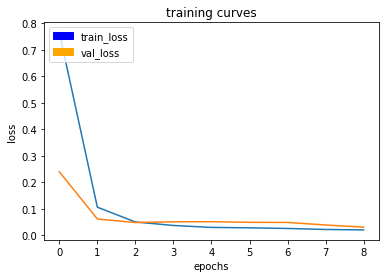

66/66 [==============================] - 119s - loss: 0.0203 - val_loss: 0.0308
Epoch 10/200
65/66 [============================>.] - ETA: 1s - loss: 0.0196

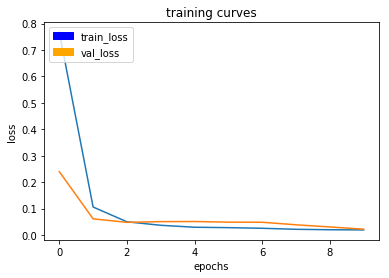

66/66 [==============================] - 120s - loss: 0.0196 - val_loss: 0.0223
Epoch 11/200
65/66 [============================>.] - ETA: 1s - loss: 0.0182

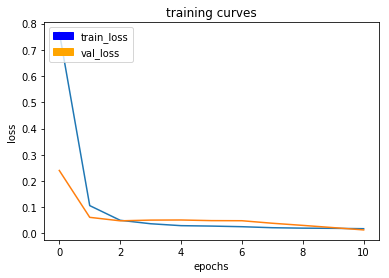

66/66 [==============================] - 119s - loss: 0.0182 - val_loss: 0.0136
Epoch 12/200
65/66 [============================>.] - ETA: 1s - loss: 0.0191

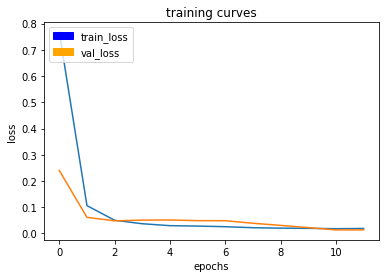

66/66 [==============================] - 119s - loss: 0.0191 - val_loss: 0.0137
Epoch 13/200
65/66 [============================>.] - ETA: 1s - loss: 0.0176

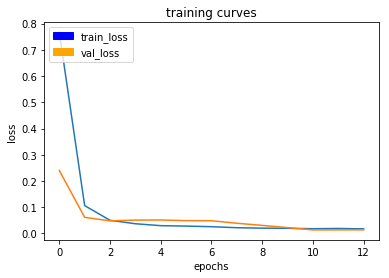

66/66 [==============================] - 121s - loss: 0.0176 - val_loss: 0.0139
Epoch 14/200
65/66 [============================>.] - ETA: 1s - loss: 0.0170

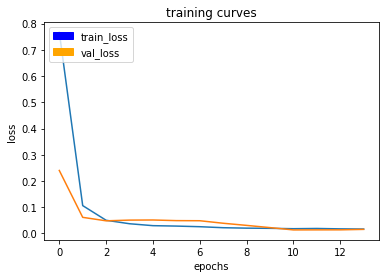

66/66 [==============================] - 120s - loss: 0.0171 - val_loss: 0.0156
Epoch 15/200
65/66 [============================>.] - ETA: 1s - loss: 0.0161

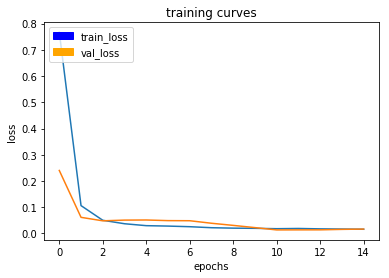

66/66 [==============================] - 120s - loss: 0.0160 - val_loss: 0.0168
Epoch 16/200
65/66 [============================>.] - ETA: 1s - loss: 0.0152

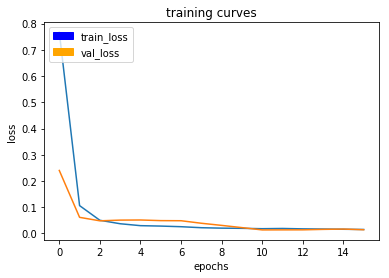

66/66 [==============================] - 122s - loss: 0.0152 - val_loss: 0.0142
Epoch 17/200
65/66 [============================>.] - ETA: 1s - loss: 0.0150

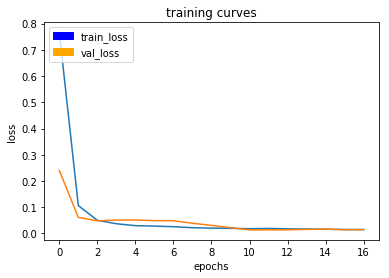

66/66 [==============================] - 120s - loss: 0.0150 - val_loss: 0.0146
Epoch 18/200
65/66 [============================>.] - ETA: 1s - loss: 0.0140

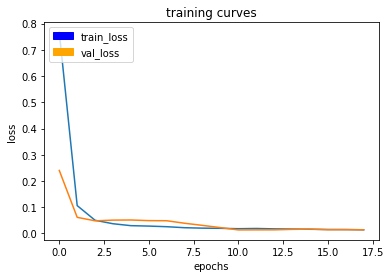

66/66 [==============================] - 120s - loss: 0.0140 - val_loss: 0.0141
Epoch 19/200
65/66 [============================>.] - ETA: 1s - loss: 0.0161

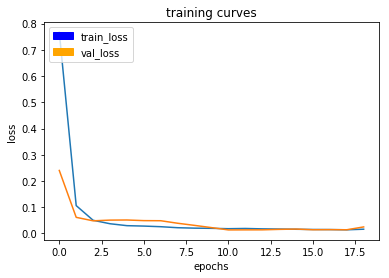

66/66 [==============================] - 122s - loss: 0.0163 - val_loss: 0.0250
Epoch 20/200
65/66 [============================>.] - ETA: 1s - loss: 0.0192

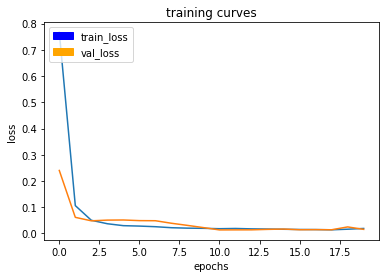

66/66 [==============================] - 120s - loss: 0.0191 - val_loss: 0.0157
Epoch 21/200
65/66 [============================>.] - ETA: 1s - loss: 0.0162

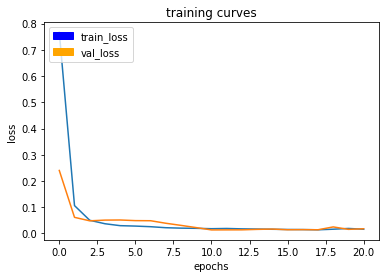

66/66 [==============================] - 121s - loss: 0.0162 - val_loss: 0.0180
Epoch 22/200
65/66 [============================>.] - ETA: 1s - loss: 0.0146

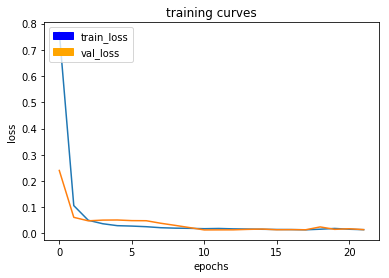

66/66 [==============================] - 122s - loss: 0.0145 - val_loss: 0.0147
Epoch 23/200
65/66 [============================>.] - ETA: 1s - loss: 0.0142

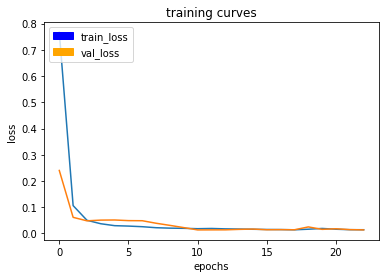

66/66 [==============================] - 120s - loss: 0.0143 - val_loss: 0.0137
Epoch 24/200
65/66 [============================>.] - ETA: 1s - loss: 0.0135

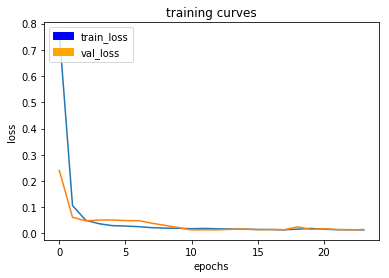

66/66 [==============================] - 122s - loss: 0.0134 - val_loss: 0.0149
Epoch 25/200
65/66 [============================>.] - ETA: 1s - loss: 0.0125

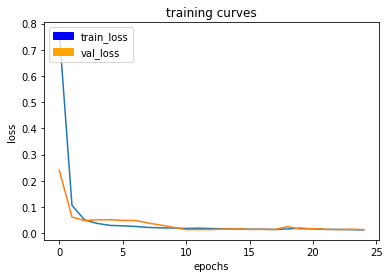

66/66 [==============================] - 120s - loss: 0.0125 - val_loss: 0.0138
Epoch 26/200
65/66 [============================>.] - ETA: 1s - loss: 0.0129

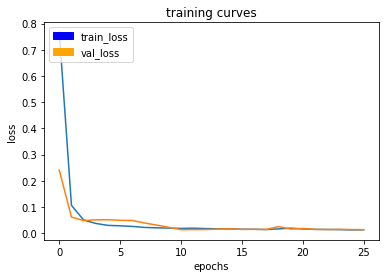

66/66 [==============================] - 120s - loss: 0.0129 - val_loss: 0.0135
Epoch 27/200
65/66 [============================>.] - ETA: 1s - loss: 0.0125

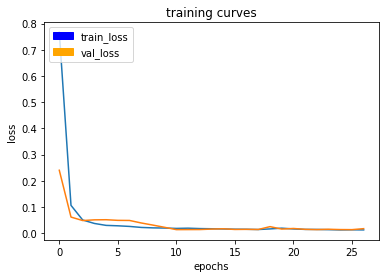

66/66 [==============================] - 122s - loss: 0.0124 - val_loss: 0.0173
Epoch 28/200
65/66 [============================>.] - ETA: 1s - loss: 0.0122

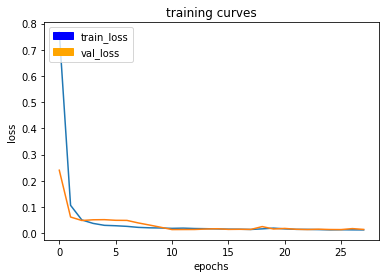

66/66 [==============================] - 122s - loss: 0.0122 - val_loss: 0.0141
Epoch 29/200
65/66 [============================>.] - ETA: 1s - loss: 0.0120

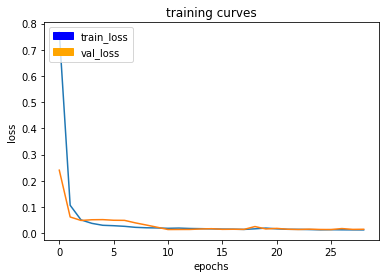

66/66 [==============================] - 120s - loss: 0.0120 - val_loss: 0.0146
Epoch 30/200
65/66 [============================>.] - ETA: 1s - loss: 0.0120

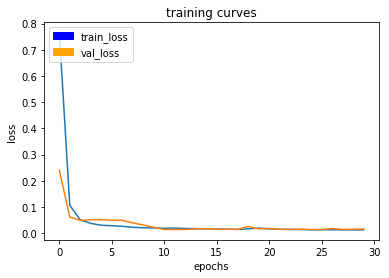

66/66 [==============================] - 123s - loss: 0.0120 - val_loss: 0.0155
Epoch 31/200
65/66 [============================>.] - ETA: 1s - loss: 0.0115

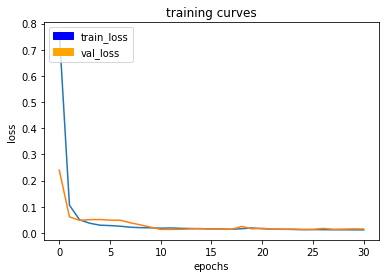

66/66 [==============================] - 120s - loss: 0.0116 - val_loss: 0.0151
Epoch 32/200
65/66 [============================>.] - ETA: 1s - loss: 0.0114

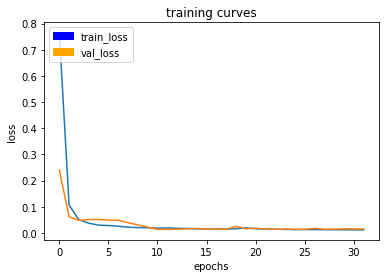

66/66 [==============================] - 120s - loss: 0.0114 - val_loss: 0.0151
Epoch 33/200
65/66 [============================>.] - ETA: 1s - loss: 0.0112

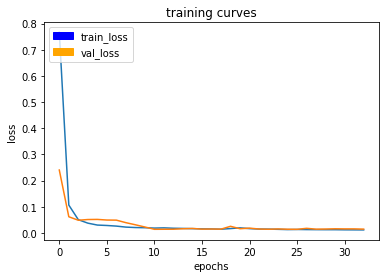

66/66 [==============================] - 121s - loss: 0.0112 - val_loss: 0.0142
Epoch 34/200
65/66 [============================>.] - ETA: 1s - loss: 0.0114

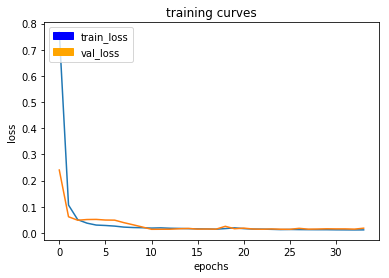

66/66 [==============================] - 120s - loss: 0.0113 - val_loss: 0.0178
Epoch 35/200
65/66 [============================>.] - ETA: 1s - loss: 0.0109

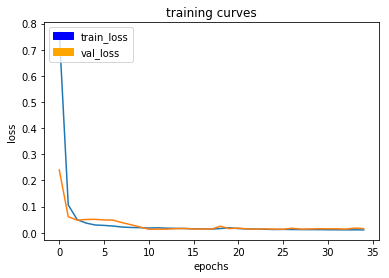

66/66 [==============================] - 119s - loss: 0.0109 - val_loss: 0.0158
Epoch 36/200
65/66 [============================>.] - ETA: 1s - loss: 0.0111

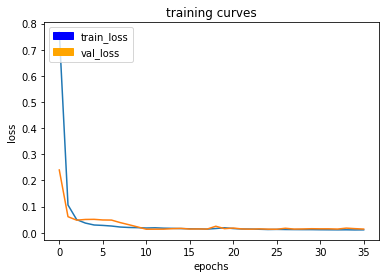

66/66 [==============================] - 121s - loss: 0.0112 - val_loss: 0.0142
Epoch 37/200
65/66 [============================>.] - ETA: 1s - loss: 0.0110

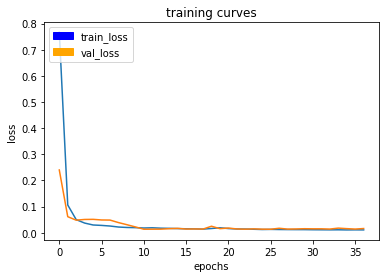

66/66 [==============================] - 119s - loss: 0.0110 - val_loss: 0.0162
Epoch 38/200
65/66 [============================>.] - ETA: 1s - loss: 0.0109

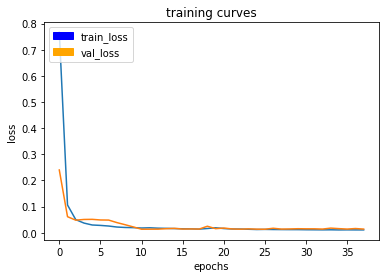

66/66 [==============================] - 121s - loss: 0.0109 - val_loss: 0.0141
Epoch 39/200
65/66 [============================>.] - ETA: 1s - loss: 0.0105

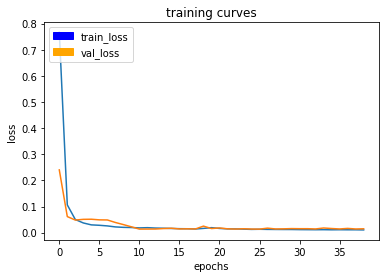

66/66 [==============================] - 123s - loss: 0.0105 - val_loss: 0.0148
Epoch 40/200
65/66 [============================>.] - ETA: 1s - loss: 0.0104

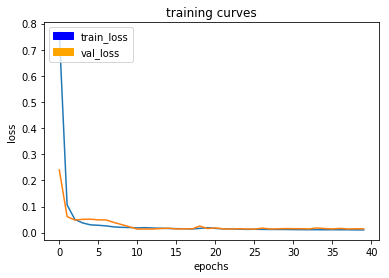

66/66 [==============================] - 119s - loss: 0.0104 - val_loss: 0.0146
Epoch 41/200
65/66 [============================>.] - ETA: 1s - loss: 0.0105

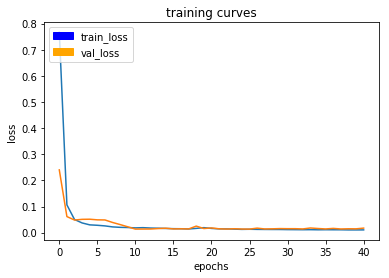

66/66 [==============================] - 121s - loss: 0.0105 - val_loss: 0.0173
Epoch 42/200
65/66 [============================>.] - ETA: 1s - loss: 0.0101

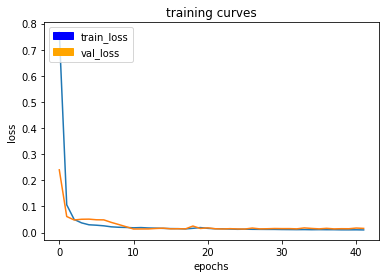

66/66 [==============================] - 121s - loss: 0.0101 - val_loss: 0.0159
Epoch 43/200
65/66 [============================>.] - ETA: 1s - loss: 0.0098

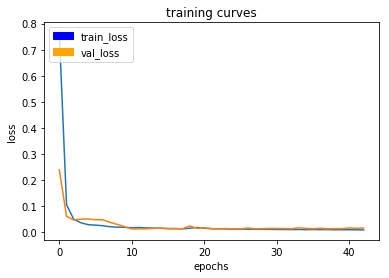

66/66 [==============================] - 119s - loss: 0.0098 - val_loss: 0.0170
Epoch 44/200
65/66 [============================>.] - ETA: 1s - loss: 0.0098

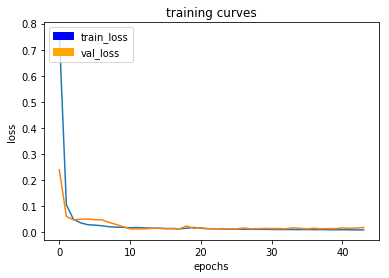

66/66 [==============================] - 120s - loss: 0.0099 - val_loss: 0.0192
Epoch 45/200
65/66 [============================>.] - ETA: 1s - loss: 0.0100

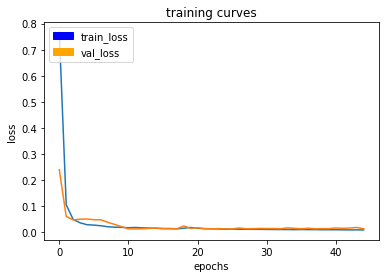

66/66 [==============================] - 123s - loss: 0.0099 - val_loss: 0.0141
Epoch 46/200
65/66 [============================>.] - ETA: 1s - loss: 0.0105

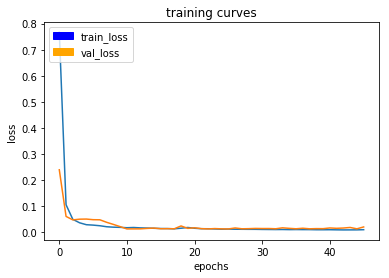

66/66 [==============================] - 119s - loss: 0.0106 - val_loss: 0.0212
Epoch 47/200
65/66 [============================>.] - ETA: 1s - loss: 0.0175

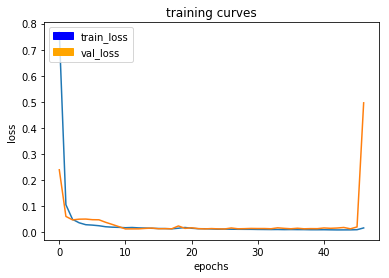

66/66 [==============================] - 120s - loss: 0.0174 - val_loss: 0.4966
Epoch 48/200
65/66 [============================>.] - ETA: 1s - loss: 0.0143

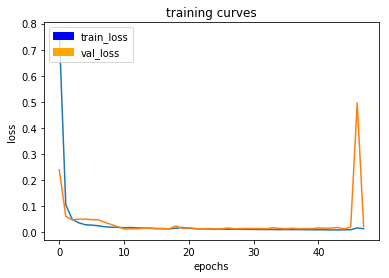

66/66 [==============================] - 122s - loss: 0.0143 - val_loss: 0.0223
Epoch 49/200
65/66 [============================>.] - ETA: 1s - loss: 0.0127

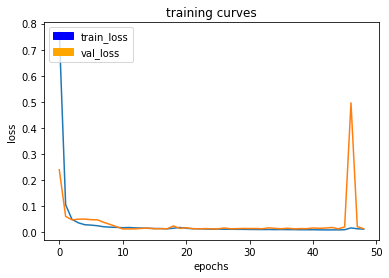

66/66 [==============================] - 120s - loss: 0.0127 - val_loss: 0.0144
Epoch 50/200
65/66 [============================>.] - ETA: 1s - loss: 0.0114

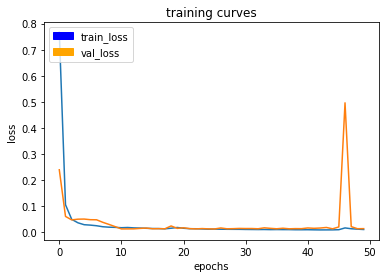

66/66 [==============================] - 120s - loss: 0.0114 - val_loss: 0.0147
Epoch 51/200
65/66 [============================>.] - ETA: 1s - loss: 0.0107

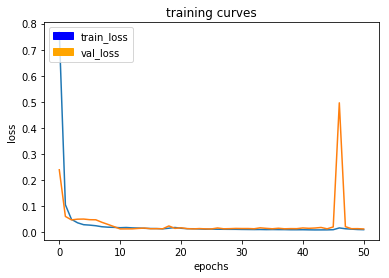

66/66 [==============================] - 121s - loss: 0.0108 - val_loss: 0.0135
Epoch 52/200
65/66 [============================>.] - ETA: 1s - loss: 0.0102

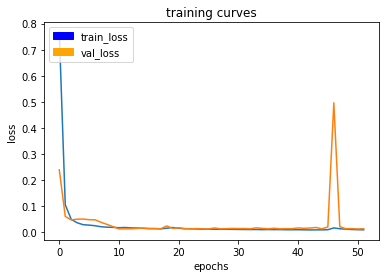

66/66 [==============================] - 120s - loss: 0.0102 - val_loss: 0.0143
Epoch 53/200
65/66 [============================>.] - ETA: 1s - loss: 0.0100

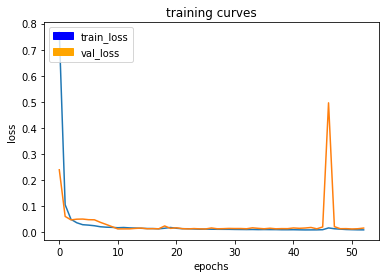

66/66 [==============================] - 123s - loss: 0.0100 - val_loss: 0.0169
Epoch 54/200
65/66 [============================>.] - ETA: 1s - loss: 0.0097

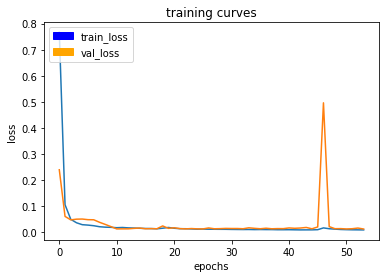

66/66 [==============================] - 120s - loss: 0.0097 - val_loss: 0.0132
Epoch 55/200
65/66 [============================>.] - ETA: 1s - loss: 0.0097

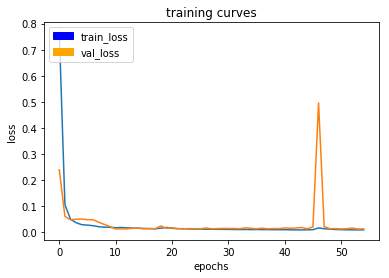

66/66 [==============================] - 120s - loss: 0.0098 - val_loss: 0.0136
Epoch 56/200
65/66 [============================>.] - ETA: 1s - loss: 0.0093

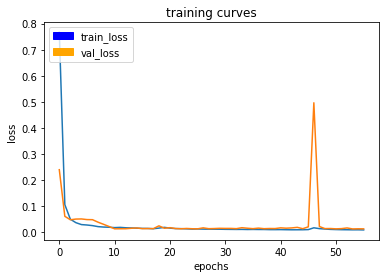

66/66 [==============================] - 121s - loss: 0.0093 - val_loss: 0.0134
Epoch 57/200
65/66 [============================>.] - ETA: 1s - loss: 0.0097

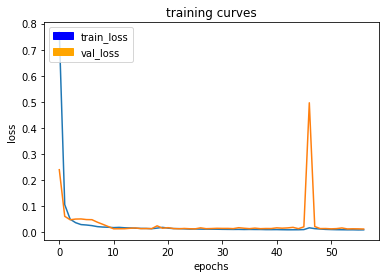

66/66 [==============================] - 119s - loss: 0.0096 - val_loss: 0.0128
Epoch 58/200
65/66 [============================>.] - ETA: 1s - loss: 0.0091

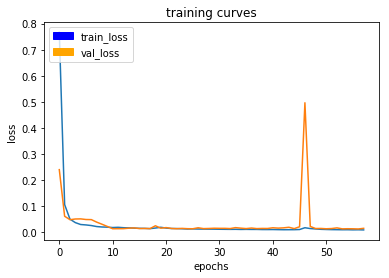

66/66 [==============================] - 118s - loss: 0.0091 - val_loss: 0.0152
Epoch 59/200
65/66 [============================>.] - ETA: 1s - loss: 0.0090

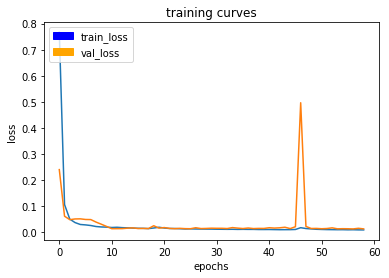

66/66 [==============================] - 118s - loss: 0.0089 - val_loss: 0.0129
Epoch 60/200
65/66 [============================>.] - ETA: 1s - loss: 0.0089

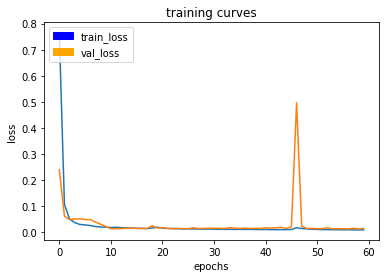

66/66 [==============================] - 119s - loss: 0.0090 - val_loss: 0.0146
Epoch 61/200
65/66 [============================>.] - ETA: 1s - loss: 0.0090

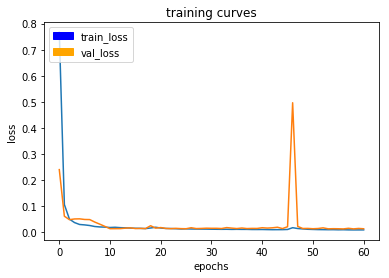

66/66 [==============================] - 118s - loss: 0.0090 - val_loss: 0.0133
Epoch 62/200
65/66 [============================>.] - ETA: 1s - loss: 0.0093

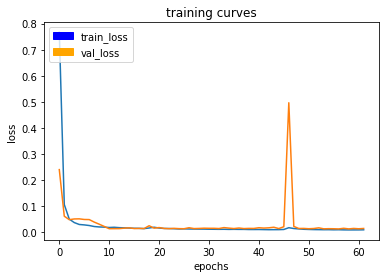

66/66 [==============================] - 118s - loss: 0.0093 - val_loss: 0.0145
Epoch 63/200
65/66 [============================>.] - ETA: 1s - loss: 0.0095

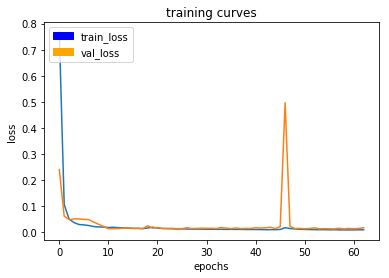

66/66 [==============================] - 118s - loss: 0.0095 - val_loss: 0.0172
Epoch 64/200
65/66 [============================>.] - ETA: 1s - loss: 0.0091

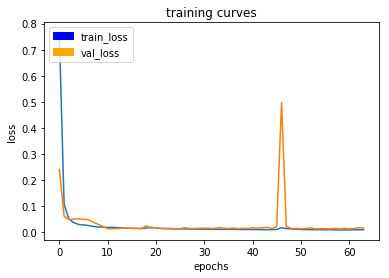

66/66 [==============================] - 118s - loss: 0.0091 - val_loss: 0.0159
Epoch 65/200
65/66 [============================>.] - ETA: 1s - loss: 0.0092

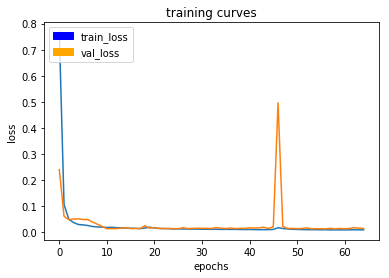

66/66 [==============================] - 119s - loss: 0.0091 - val_loss: 0.0145
Epoch 66/200
65/66 [============================>.] - ETA: 1s - loss: 0.0086

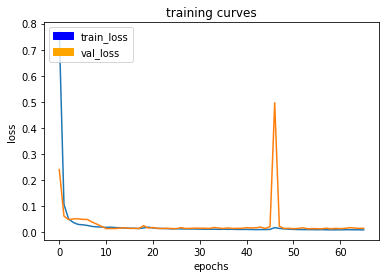

66/66 [==============================] - 119s - loss: 0.0086 - val_loss: 0.0149
Epoch 67/200
65/66 [============================>.] - ETA: 1s - loss: 0.0089

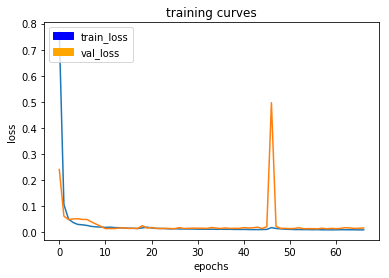

66/66 [==============================] - 118s - loss: 0.0090 - val_loss: 0.0160
Epoch 68/200
65/66 [============================>.] - ETA: 1s - loss: 0.0090

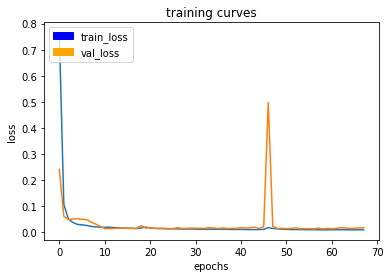

66/66 [==============================] - 118s - loss: 0.0089 - val_loss: 0.0169
Epoch 69/200
65/66 [============================>.] - ETA: 1s - loss: 0.0089

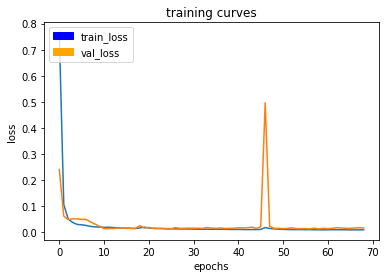

66/66 [==============================] - 118s - loss: 0.0088 - val_loss: 0.0160
Epoch 70/200
65/66 [============================>.] - ETA: 1s - loss: 0.0086

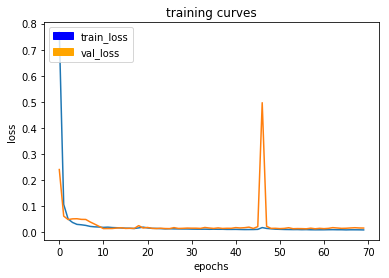

66/66 [==============================] - 119s - loss: 0.0085 - val_loss: 0.0156
Epoch 71/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

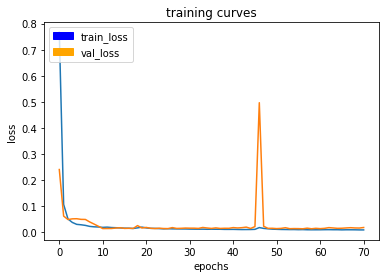

66/66 [==============================] - 120s - loss: 0.0084 - val_loss: 0.0177
Epoch 72/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

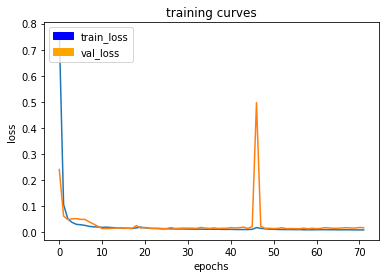

66/66 [==============================] - 119s - loss: 0.0084 - val_loss: 0.0169
Epoch 73/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

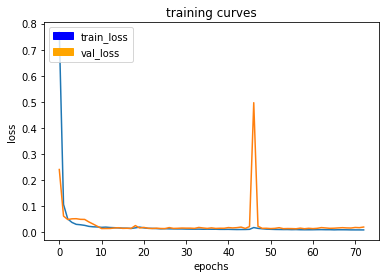

66/66 [==============================] - 118s - loss: 0.0084 - val_loss: 0.0194
Epoch 74/200
65/66 [============================>.] - ETA: 1s - loss: 0.0170

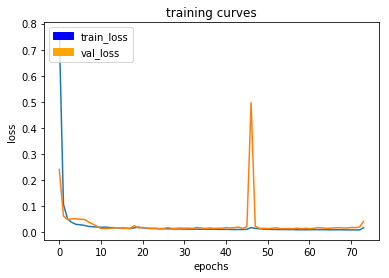

66/66 [==============================] - 119s - loss: 0.0169 - val_loss: 0.0409
Epoch 75/200
65/66 [============================>.] - ETA: 1s - loss: 0.0123

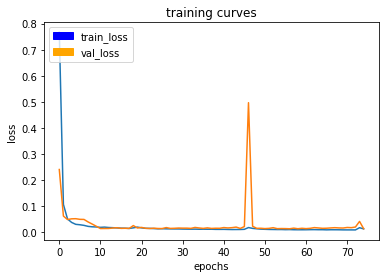

66/66 [==============================] - 118s - loss: 0.0123 - val_loss: 0.0130
Epoch 76/200
65/66 [============================>.] - ETA: 1s - loss: 0.0106

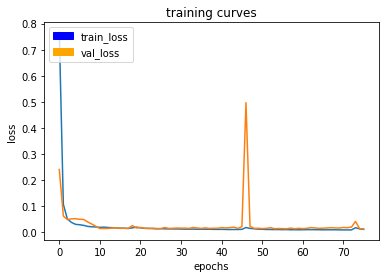

66/66 [==============================] - 118s - loss: 0.0105 - val_loss: 0.0123
Epoch 77/200
65/66 [============================>.] - ETA: 1s - loss: 0.0097

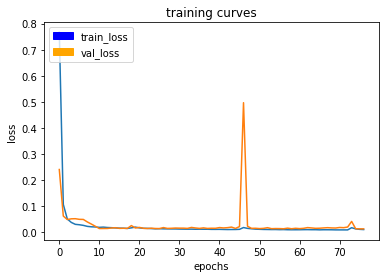

66/66 [==============================] - 117s - loss: 0.0097 - val_loss: 0.0124
Epoch 78/200
65/66 [============================>.] - ETA: 1s - loss: 0.0092

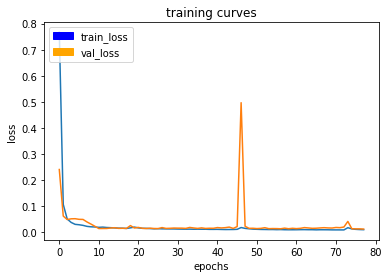

66/66 [==============================] - 118s - loss: 0.0092 - val_loss: 0.0115
Epoch 79/200
65/66 [============================>.] - ETA: 1s - loss: 0.0089

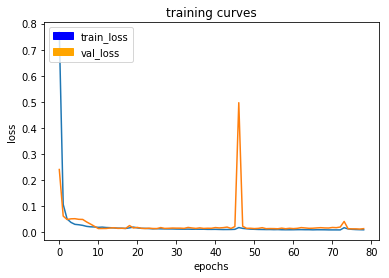

66/66 [==============================] - 118s - loss: 0.0089 - val_loss: 0.0132
Epoch 80/200
65/66 [============================>.] - ETA: 1s - loss: 0.0087

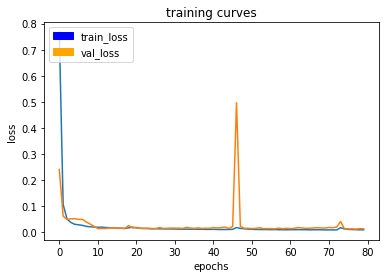

66/66 [==============================] - 119s - loss: 0.0087 - val_loss: 0.0127
Epoch 81/200
65/66 [============================>.] - ETA: 1s - loss: 0.0086

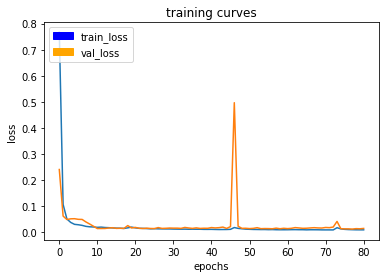

66/66 [==============================] - 119s - loss: 0.0086 - val_loss: 0.0140
Epoch 82/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

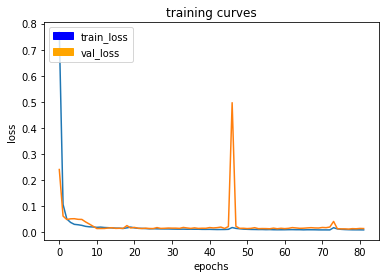

66/66 [==============================] - 121s - loss: 0.0084 - val_loss: 0.0135
Epoch 83/200
65/66 [============================>.] - ETA: 1s - loss: 0.0081

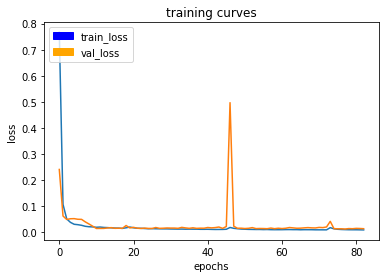

66/66 [==============================] - 120s - loss: 0.0081 - val_loss: 0.0128
Epoch 84/200
65/66 [============================>.] - ETA: 1s - loss: 0.0081

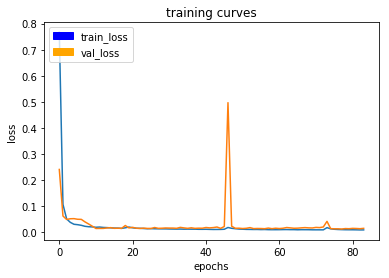

66/66 [==============================] - 118s - loss: 0.0082 - val_loss: 0.0141
Epoch 85/200
65/66 [============================>.] - ETA: 1s - loss: 0.0081

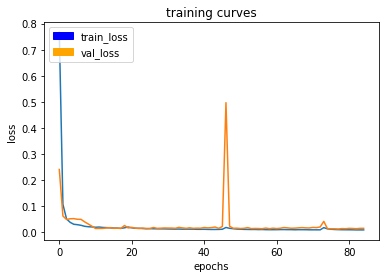

66/66 [==============================] - 118s - loss: 0.0081 - val_loss: 0.0141
Epoch 86/200
65/66 [============================>.] - ETA: 1s - loss: 0.0080

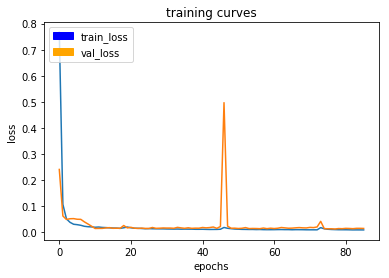

66/66 [==============================] - 118s - loss: 0.0080 - val_loss: 0.0136
Epoch 87/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

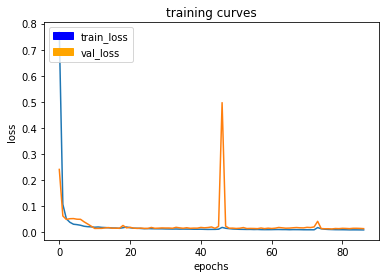

66/66 [==============================] - 118s - loss: 0.0079 - val_loss: 0.0128
Epoch 88/200
65/66 [============================>.] - ETA: 1s - loss: 0.0081

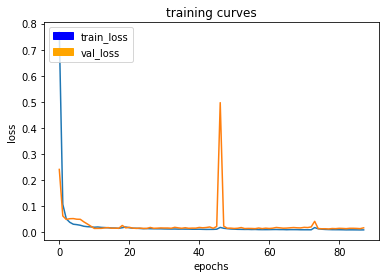

66/66 [==============================] - 118s - loss: 0.0080 - val_loss: 0.0159
Epoch 89/200
65/66 [============================>.] - ETA: 1s - loss: 0.0078

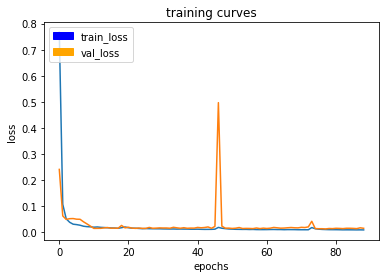

66/66 [==============================] - 119s - loss: 0.0078 - val_loss: 0.0140
Epoch 90/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

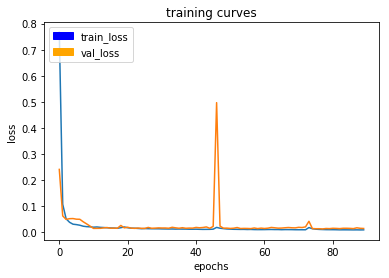

66/66 [==============================] - 120s - loss: 0.0079 - val_loss: 0.0133
Epoch 91/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

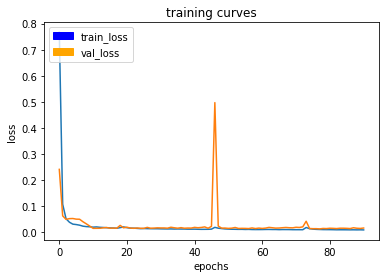

66/66 [==============================] - 119s - loss: 0.0076 - val_loss: 0.0148
Epoch 92/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

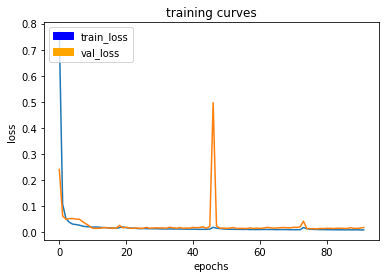

66/66 [==============================] - 118s - loss: 0.0079 - val_loss: 0.0168
Epoch 93/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

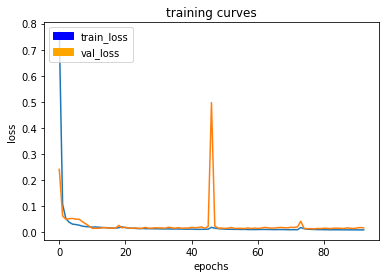

66/66 [==============================] - 120s - loss: 0.0076 - val_loss: 0.0153
Epoch 94/200
65/66 [============================>.] - ETA: 1s - loss: 0.0077

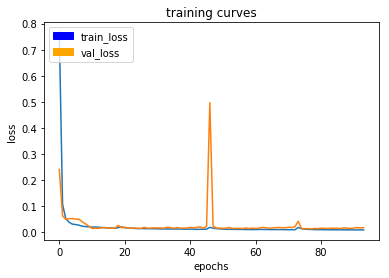

66/66 [==============================] - 119s - loss: 0.0077 - val_loss: 0.0163
Epoch 95/200
65/66 [============================>.] - ETA: 1s - loss: 0.0075

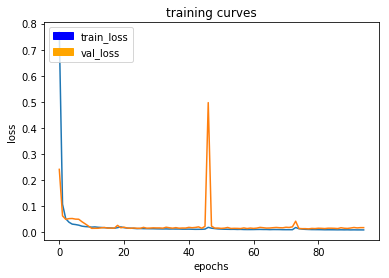

66/66 [==============================] - 120s - loss: 0.0075 - val_loss: 0.0163
Epoch 96/200
65/66 [============================>.] - ETA: 1s - loss: 0.0075

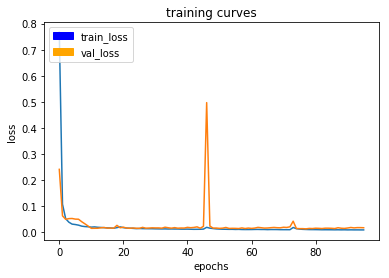

66/66 [==============================] - 119s - loss: 0.0075 - val_loss: 0.0158
Epoch 97/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

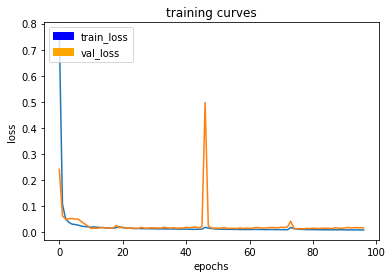

66/66 [==============================] - 119s - loss: 0.0076 - val_loss: 0.0161
Epoch 98/200
65/66 [============================>.] - ETA: 1s - loss: 0.0289

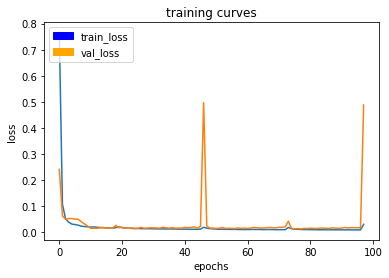

66/66 [==============================] - 118s - loss: 0.0289 - val_loss: 0.4872
Epoch 99/200
65/66 [============================>.] - ETA: 1s - loss: 0.0223

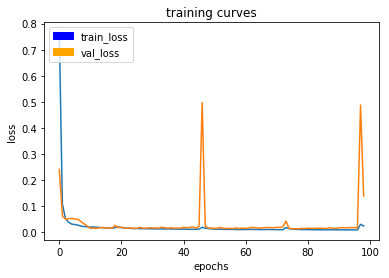

66/66 [==============================] - 118s - loss: 0.0223 - val_loss: 0.1377
Epoch 100/200
65/66 [============================>.] - ETA: 1s - loss: 0.0164

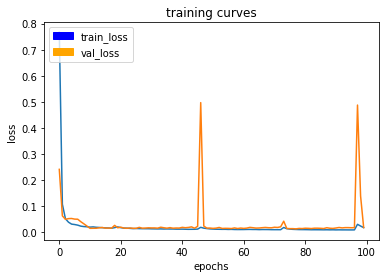

66/66 [==============================] - 119s - loss: 0.0164 - val_loss: 0.0166
Epoch 101/200
65/66 [============================>.] - ETA: 1s - loss: 0.0146

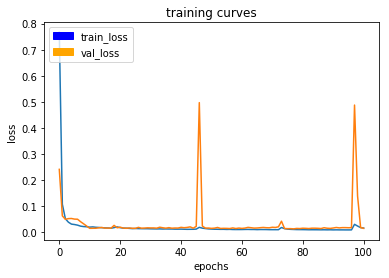

66/66 [==============================] - 119s - loss: 0.0146 - val_loss: 0.0135
Epoch 102/200
65/66 [============================>.] - ETA: 1s - loss: 0.0133

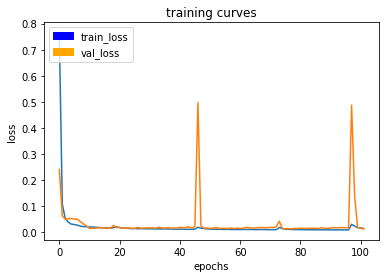

66/66 [==============================] - 120s - loss: 0.0133 - val_loss: 0.0116
Epoch 103/200
65/66 [============================>.] - ETA: 1s - loss: 0.0127

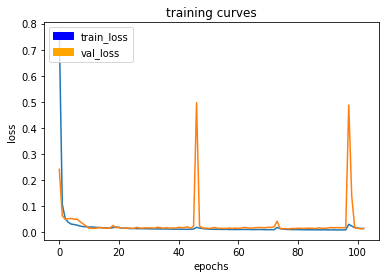

66/66 [==============================] - 120s - loss: 0.0126 - val_loss: 0.0131
Epoch 104/200
65/66 [============================>.] - ETA: 1s - loss: 0.0121

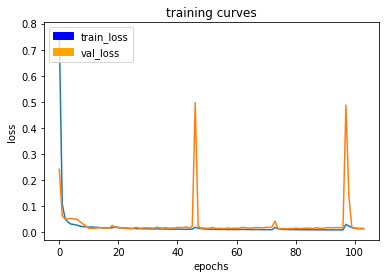

66/66 [==============================] - 119s - loss: 0.0120 - val_loss: 0.0132
Epoch 105/200
65/66 [============================>.] - ETA: 1s - loss: 0.0116

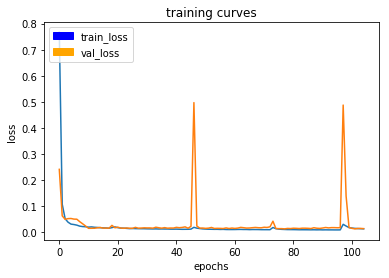

66/66 [==============================] - 118s - loss: 0.0116 - val_loss: 0.0125
Epoch 106/200
65/66 [============================>.] - ETA: 1s - loss: 0.0111

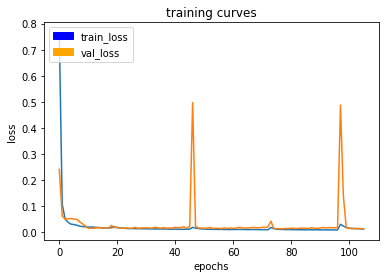

66/66 [==============================] - 118s - loss: 0.0111 - val_loss: 0.0116
Epoch 107/200
65/66 [============================>.] - ETA: 1s - loss: 0.0112

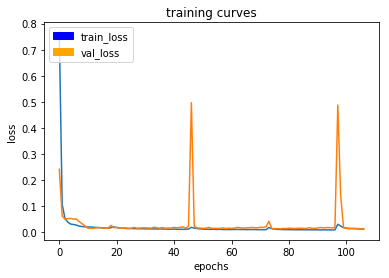

66/66 [==============================] - 118s - loss: 0.0111 - val_loss: 0.0124
Epoch 108/200
65/66 [============================>.] - ETA: 1s - loss: 0.0109

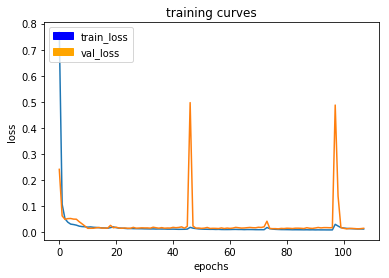

66/66 [==============================] - 119s - loss: 0.0109 - val_loss: 0.0137
Epoch 109/200
65/66 [============================>.] - ETA: 1s - loss: 0.0128

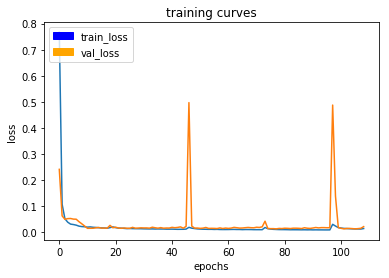

66/66 [==============================] - 118s - loss: 0.0127 - val_loss: 0.0200
Epoch 110/200
65/66 [============================>.] - ETA: 1s - loss: 0.0116

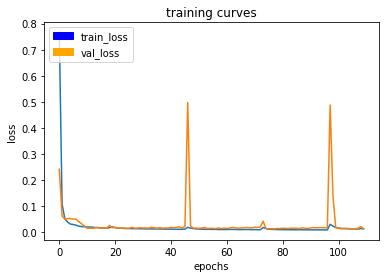

66/66 [==============================] - 119s - loss: 0.0116 - val_loss: 0.0118
Epoch 111/200
65/66 [============================>.] - ETA: 1s - loss: 0.0105

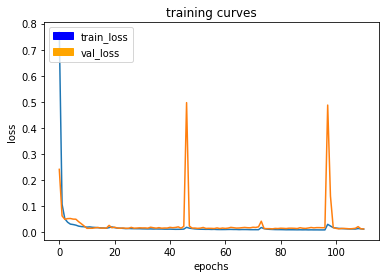

66/66 [==============================] - 118s - loss: 0.0105 - val_loss: 0.0111
Epoch 112/200
65/66 [============================>.] - ETA: 1s - loss: 0.0106

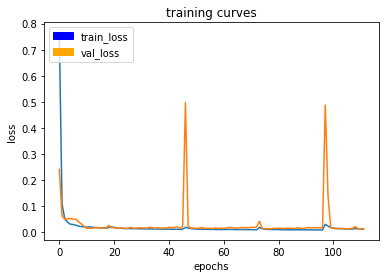

66/66 [==============================] - 118s - loss: 0.0105 - val_loss: 0.0120
Epoch 113/200
65/66 [============================>.] - ETA: 1s - loss: 0.0100

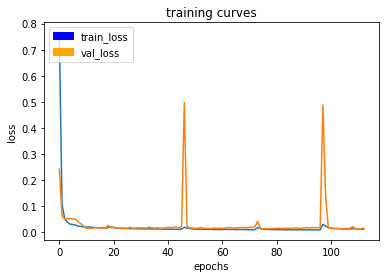

66/66 [==============================] - 119s - loss: 0.0100 - val_loss: 0.0145
Epoch 114/200
65/66 [============================>.] - ETA: 1s - loss: 0.0100

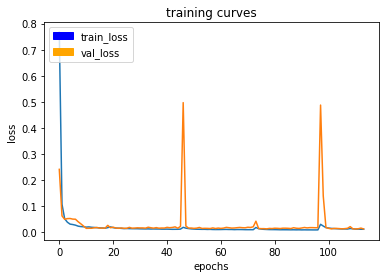

66/66 [==============================] - 119s - loss: 0.0100 - val_loss: 0.0111
Epoch 115/200
65/66 [============================>.] - ETA: 1s - loss: 0.0098

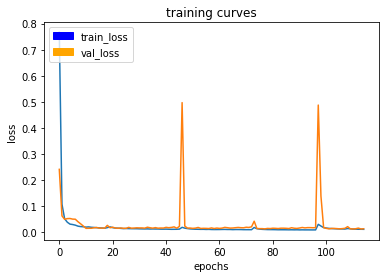

66/66 [==============================] - 121s - loss: 0.0098 - val_loss: 0.0119
Epoch 116/200
65/66 [============================>.] - ETA: 1s - loss: 0.0097

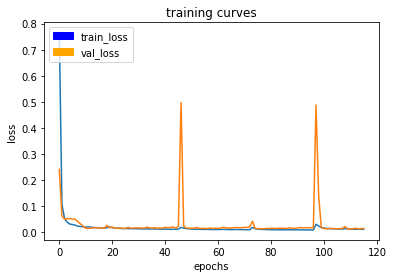

66/66 [==============================] - 119s - loss: 0.0097 - val_loss: 0.0131
Epoch 117/200
65/66 [============================>.] - ETA: 1s - loss: 0.0096

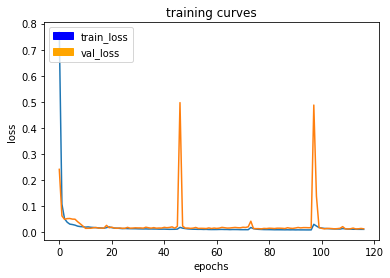

66/66 [==============================] - 118s - loss: 0.0097 - val_loss: 0.0117
Epoch 118/200
65/66 [============================>.] - ETA: 1s - loss: 0.0094

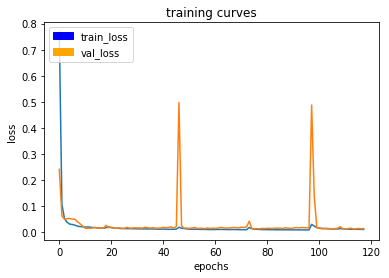

66/66 [==============================] - 121s - loss: 0.0094 - val_loss: 0.0126
Epoch 119/200
65/66 [============================>.] - ETA: 1s - loss: 0.0095

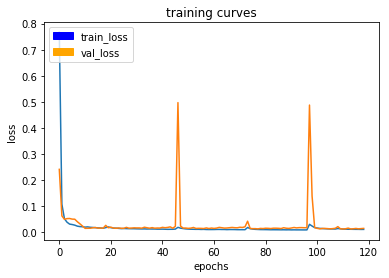

66/66 [==============================] - 118s - loss: 0.0095 - val_loss: 0.0133
Epoch 120/200
65/66 [============================>.] - ETA: 1s - loss: 0.0090

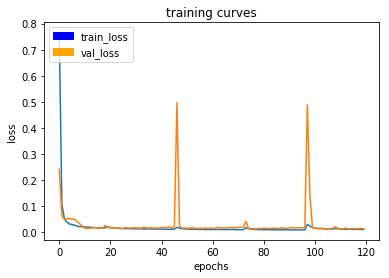

66/66 [==============================] - 119s - loss: 0.0091 - val_loss: 0.0126
Epoch 121/200
65/66 [============================>.] - ETA: 1s - loss: 0.0091

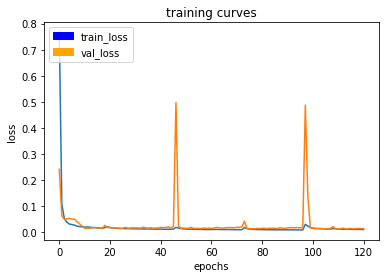

66/66 [==============================] - 120s - loss: 0.0091 - val_loss: 0.0123
Epoch 122/200
65/66 [============================>.] - ETA: 1s - loss: 0.0093

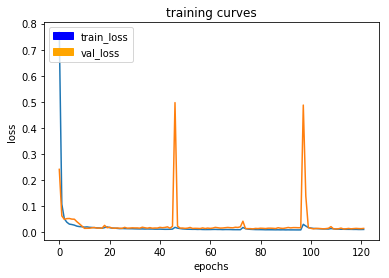

66/66 [==============================] - 118s - loss: 0.0093 - val_loss: 0.0132
Epoch 123/200
65/66 [============================>.] - ETA: 1s - loss: 0.0088

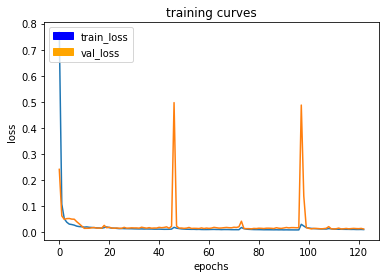

66/66 [==============================] - 121s - loss: 0.0088 - val_loss: 0.0110
Epoch 124/200
65/66 [============================>.] - ETA: 1s - loss: 0.0090

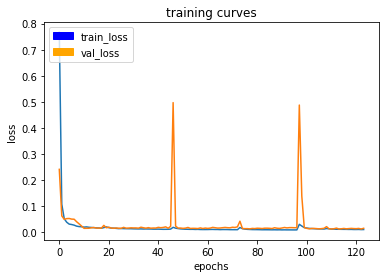

66/66 [==============================] - 119s - loss: 0.0090 - val_loss: 0.0138
Epoch 125/200
65/66 [============================>.] - ETA: 1s - loss: 0.0088

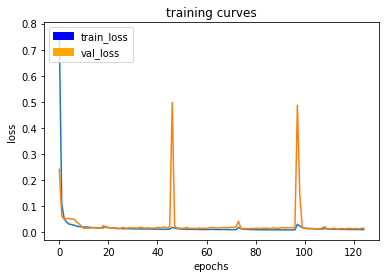

66/66 [==============================] - 119s - loss: 0.0088 - val_loss: 0.0137
Epoch 126/200
65/66 [============================>.] - ETA: 1s - loss: 0.0087

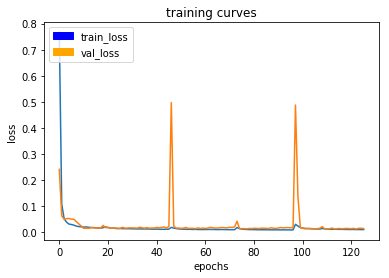

66/66 [==============================] - 119s - loss: 0.0088 - val_loss: 0.0126
Epoch 127/200
65/66 [============================>.] - ETA: 1s - loss: 0.0087

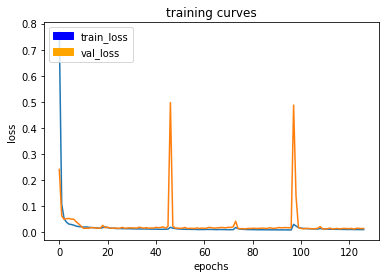

66/66 [==============================] - 121s - loss: 0.0087 - val_loss: 0.0130
Epoch 128/200
65/66 [============================>.] - ETA: 1s - loss: 0.0087

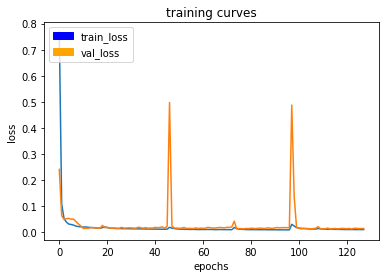

66/66 [==============================] - 122s - loss: 0.0088 - val_loss: 0.0128
Epoch 129/200
65/66 [============================>.] - ETA: 1s - loss: 0.0086

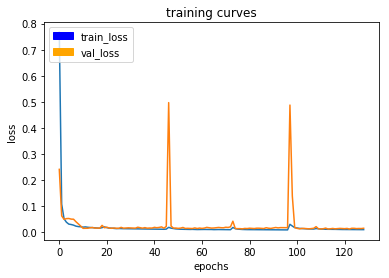

66/66 [==============================] - 120s - loss: 0.0085 - val_loss: 0.0138
Epoch 130/200
65/66 [============================>.] - ETA: 1s - loss: 0.0088

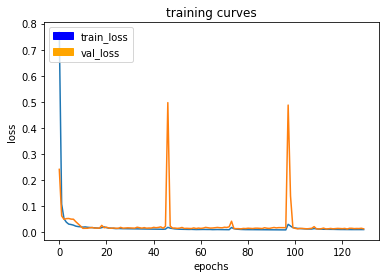

66/66 [==============================] - 119s - loss: 0.0088 - val_loss: 0.0117
Epoch 131/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

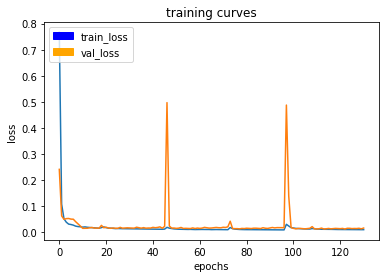

66/66 [==============================] - 121s - loss: 0.0084 - val_loss: 0.0147
Epoch 132/200
65/66 [============================>.] - ETA: 1s - loss: 0.0087

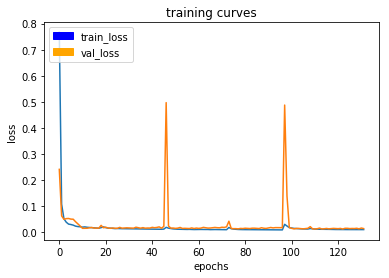

66/66 [==============================] - 119s - loss: 0.0087 - val_loss: 0.0126
Epoch 133/200
65/66 [============================>.] - ETA: 1s - loss: 0.0082

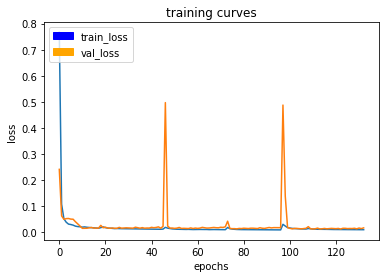

66/66 [==============================] - 120s - loss: 0.0083 - val_loss: 0.0154
Epoch 134/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

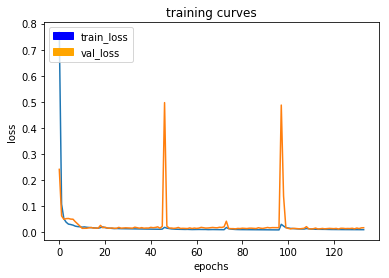

66/66 [==============================] - 120s - loss: 0.0084 - val_loss: 0.0159
Epoch 135/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

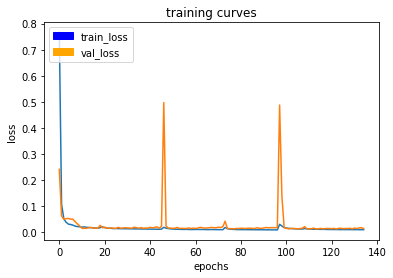

66/66 [==============================] - 119s - loss: 0.0084 - val_loss: 0.0128
Epoch 136/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

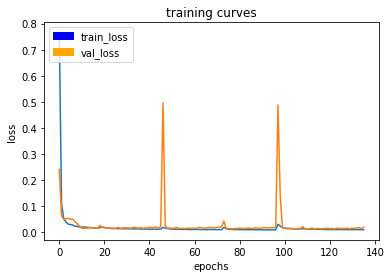

66/66 [==============================] - 119s - loss: 0.0084 - val_loss: 0.0181
Epoch 137/200
65/66 [============================>.] - ETA: 1s - loss: 0.0083

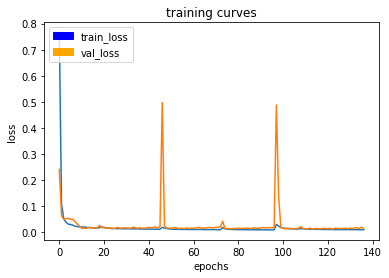

66/66 [==============================] - 119s - loss: 0.0084 - val_loss: 0.0133
Epoch 138/200
65/66 [============================>.] - ETA: 1s - loss: 0.0082

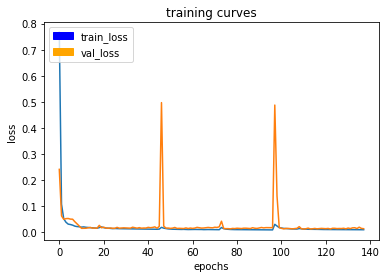

66/66 [==============================] - 120s - loss: 0.0082 - val_loss: 0.0122
Epoch 139/200
65/66 [============================>.] - ETA: 1s - loss: 0.0082

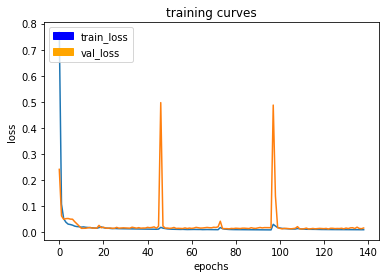

66/66 [==============================] - 119s - loss: 0.0082 - val_loss: 0.0149
Epoch 140/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

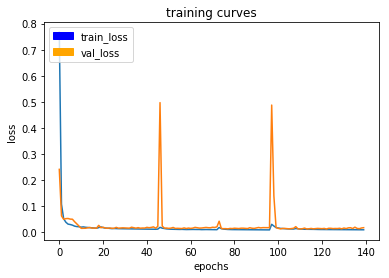

66/66 [==============================] - 120s - loss: 0.0079 - val_loss: 0.0161
Epoch 141/200
65/66 [============================>.] - ETA: 1s - loss: 0.0080

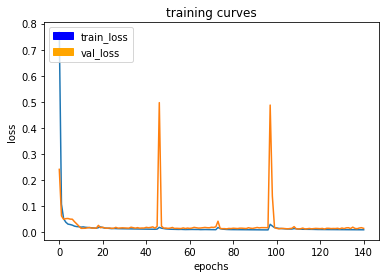

66/66 [==============================] - 119s - loss: 0.0080 - val_loss: 0.0134
Epoch 142/200
65/66 [============================>.] - ETA: 1s - loss: 0.0081

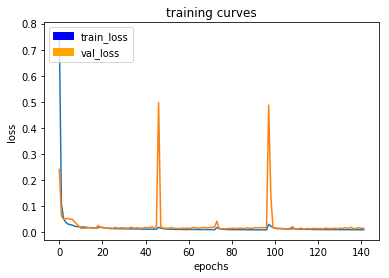

66/66 [==============================] - 119s - loss: 0.0081 - val_loss: 0.0135
Epoch 143/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

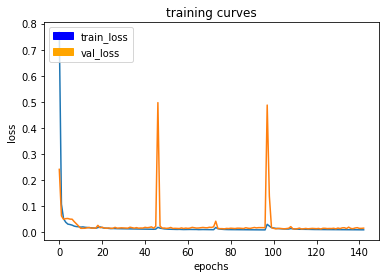

66/66 [==============================] - 118s - loss: 0.0079 - val_loss: 0.0142
Epoch 144/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

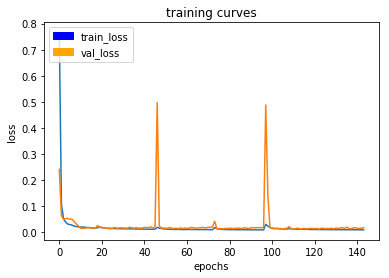

66/66 [==============================] - 119s - loss: 0.0078 - val_loss: 0.0161
Epoch 145/200
65/66 [============================>.] - ETA: 1s - loss: 0.0078

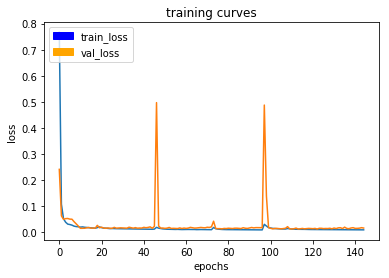

66/66 [==============================] - 118s - loss: 0.0077 - val_loss: 0.0146
Epoch 146/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

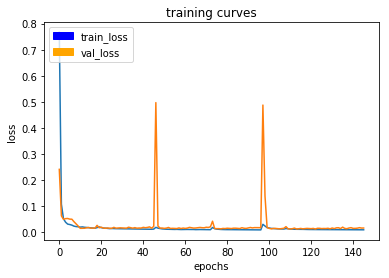

66/66 [==============================] - 119s - loss: 0.0079 - val_loss: 0.0147
Epoch 147/200
65/66 [============================>.] - ETA: 1s - loss: 0.0078

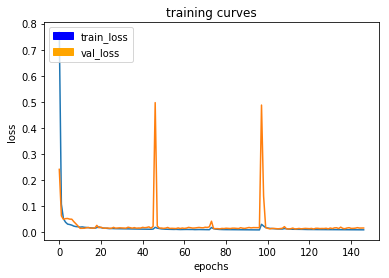

66/66 [==============================] - 119s - loss: 0.0078 - val_loss: 0.0148
Epoch 148/200
65/66 [============================>.] - ETA: 1s - loss: 0.0077

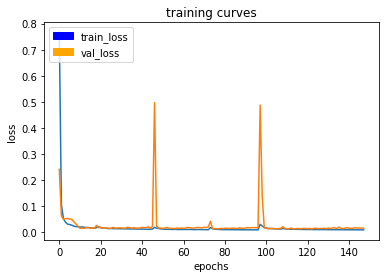

66/66 [==============================] - 119s - loss: 0.0077 - val_loss: 0.0142
Epoch 149/200
65/66 [============================>.] - ETA: 1s - loss: 0.0078

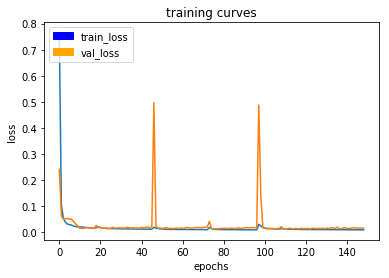

66/66 [==============================] - 119s - loss: 0.0078 - val_loss: 0.0142
Epoch 150/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

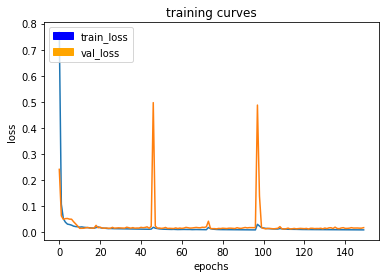

66/66 [==============================] - 119s - loss: 0.0076 - val_loss: 0.0162
Epoch 151/200
65/66 [============================>.] - ETA: 1s - loss: 0.0087

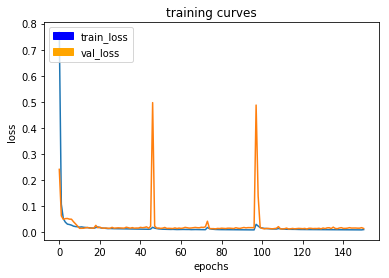

66/66 [==============================] - 119s - loss: 0.0087 - val_loss: 0.0131
Epoch 152/200
65/66 [============================>.] - ETA: 1s - loss: 0.0081

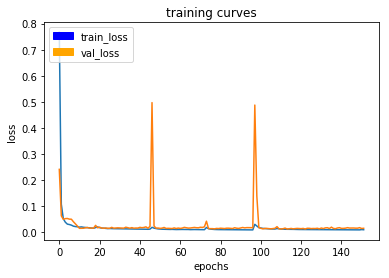

66/66 [==============================] - 119s - loss: 0.0081 - val_loss: 0.0138
Epoch 153/200
65/66 [============================>.] - ETA: 1s - loss: 0.0077

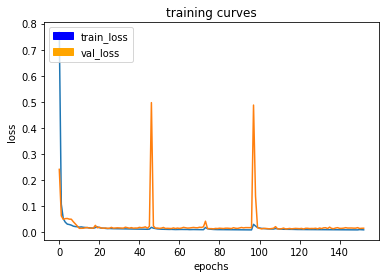

66/66 [==============================] - 119s - loss: 0.0078 - val_loss: 0.0140
Epoch 154/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

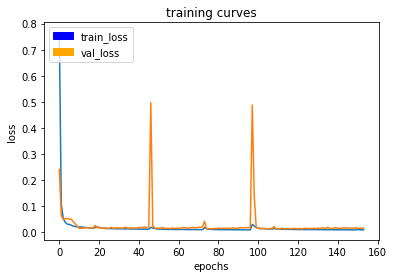

66/66 [==============================] - 119s - loss: 0.0076 - val_loss: 0.0151
Epoch 155/200
65/66 [============================>.] - ETA: 1s - loss: 0.0113

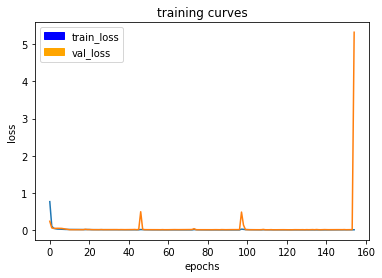

66/66 [==============================] - 119s - loss: 0.0116 - val_loss: 5.3188
Epoch 156/200
65/66 [============================>.] - ETA: 1s - loss: 0.0182

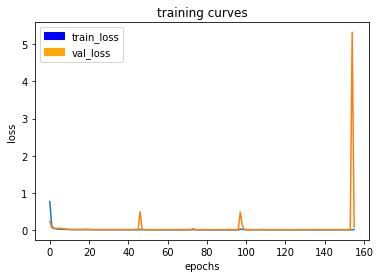

66/66 [==============================] - 119s - loss: 0.0181 - val_loss: 0.0861
Epoch 157/200
65/66 [============================>.] - ETA: 1s - loss: 0.0124

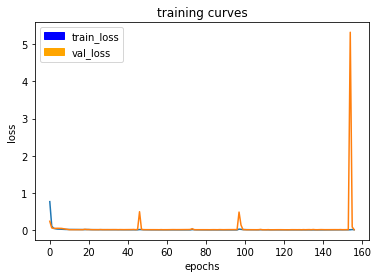

66/66 [==============================] - 119s - loss: 0.0124 - val_loss: 0.0132
Epoch 158/200
65/66 [============================>.] - ETA: 1s - loss: 0.0104

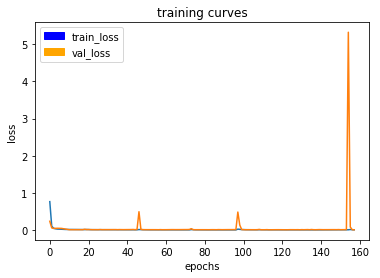

66/66 [==============================] - 120s - loss: 0.0104 - val_loss: 0.0106
Epoch 159/200
65/66 [============================>.] - ETA: 1s - loss: 0.0102

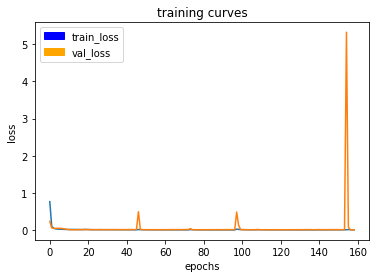

66/66 [==============================] - 119s - loss: 0.0101 - val_loss: 0.0117
Epoch 160/200
65/66 [============================>.] - ETA: 1s - loss: 0.0096

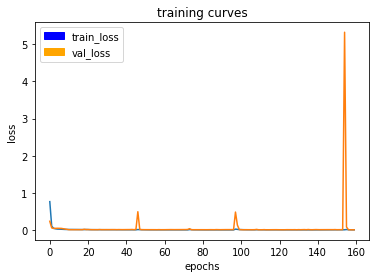

66/66 [==============================] - 118s - loss: 0.0097 - val_loss: 0.0102
Epoch 161/200
65/66 [============================>.] - ETA: 1s - loss: 0.0094

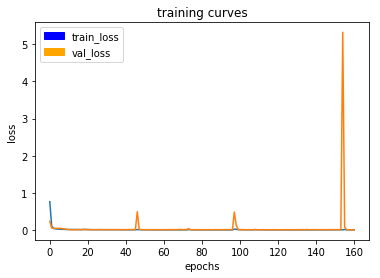

66/66 [==============================] - 119s - loss: 0.0094 - val_loss: 0.0106
Epoch 162/200
65/66 [============================>.] - ETA: 1s - loss: 0.0089

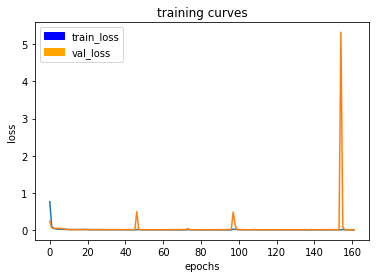

66/66 [==============================] - 118s - loss: 0.0089 - val_loss: 0.0102
Epoch 163/200
65/66 [============================>.] - ETA: 1s - loss: 0.0090

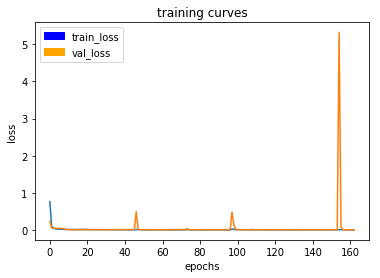

66/66 [==============================] - 119s - loss: 0.0091 - val_loss: 0.0110
Epoch 164/200
65/66 [============================>.] - ETA: 1s - loss: 0.0086

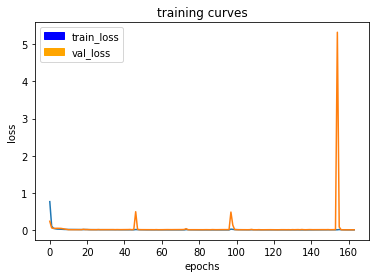

66/66 [==============================] - 118s - loss: 0.0085 - val_loss: 0.0107
Epoch 165/200
65/66 [============================>.] - ETA: 1s - loss: 0.0088

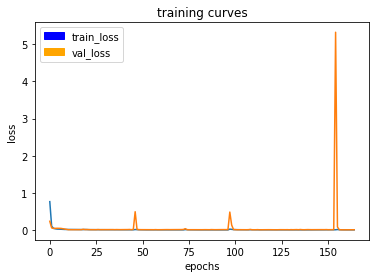

66/66 [==============================] - 120s - loss: 0.0088 - val_loss: 0.0121
Epoch 166/200
65/66 [============================>.] - ETA: 1s - loss: 0.0084

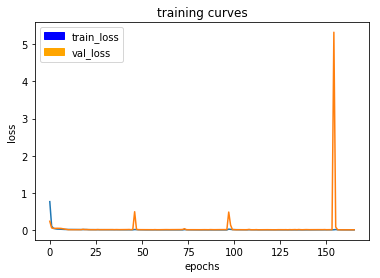

66/66 [==============================] - 119s - loss: 0.0084 - val_loss: 0.0109
Epoch 167/200
65/66 [============================>.] - ETA: 1s - loss: 0.0085

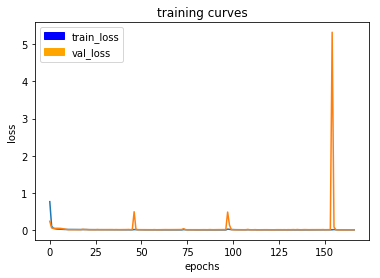

66/66 [==============================] - 119s - loss: 0.0085 - val_loss: 0.0122
Epoch 168/200
65/66 [============================>.] - ETA: 1s - loss: 0.0086

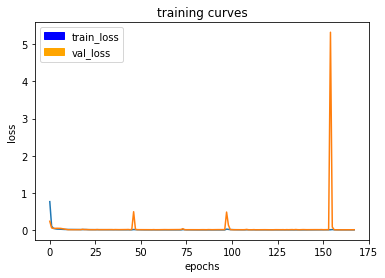

66/66 [==============================] - 119s - loss: 0.0086 - val_loss: 0.0125
Epoch 169/200
65/66 [============================>.] - ETA: 1s - loss: 0.0082

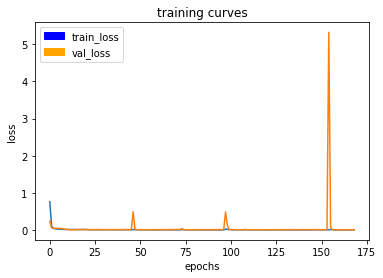

66/66 [==============================] - 119s - loss: 0.0082 - val_loss: 0.0119
Epoch 170/200
65/66 [============================>.] - ETA: 1s - loss: 0.0080

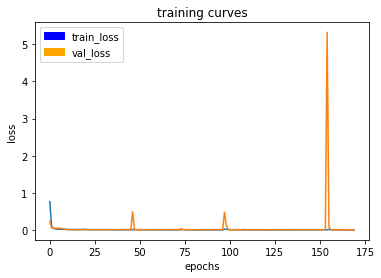

66/66 [==============================] - 119s - loss: 0.0080 - val_loss: 0.0116
Epoch 171/200
65/66 [============================>.] - ETA: 1s - loss: 0.0082

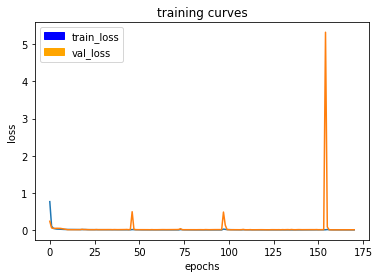

66/66 [==============================] - 119s - loss: 0.0082 - val_loss: 0.0119
Epoch 172/200
65/66 [============================>.] - ETA: 1s - loss: 0.0078

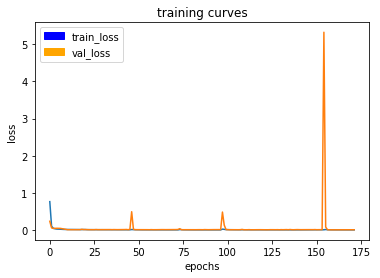

66/66 [==============================] - 118s - loss: 0.0078 - val_loss: 0.0115
Epoch 173/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

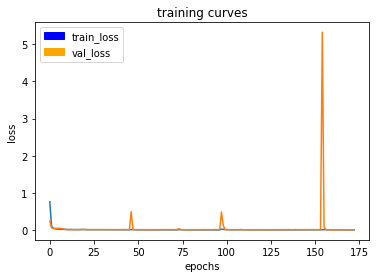

66/66 [==============================] - 119s - loss: 0.0079 - val_loss: 0.0127
Epoch 174/200
65/66 [============================>.] - ETA: 1s - loss: 0.0079

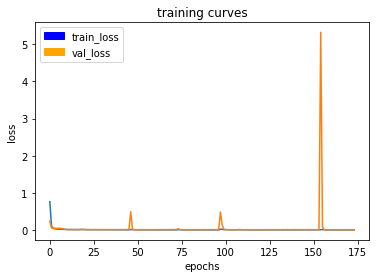

66/66 [==============================] - 118s - loss: 0.0079 - val_loss: 0.0122
Epoch 175/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

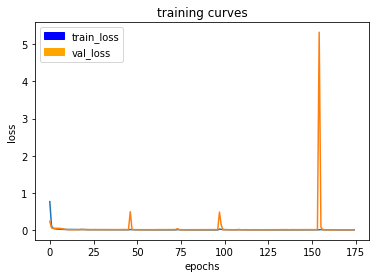

66/66 [==============================] - 119s - loss: 0.0076 - val_loss: 0.0137
Epoch 176/200
65/66 [============================>.] - ETA: 1s - loss: 0.0077

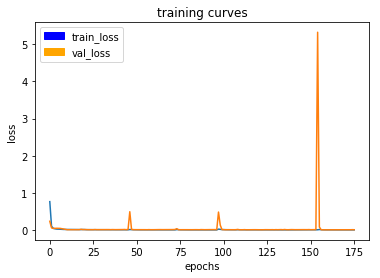

66/66 [==============================] - 120s - loss: 0.0077 - val_loss: 0.0123
Epoch 177/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

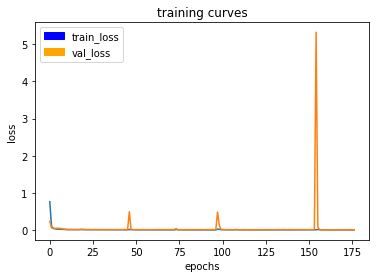

66/66 [==============================] - 119s - loss: 0.0076 - val_loss: 0.0127
Epoch 178/200
65/66 [============================>.] - ETA: 1s - loss: 0.0076

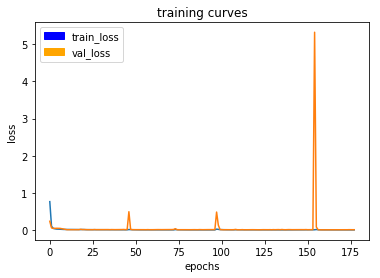

66/66 [==============================] - 120s - loss: 0.0076 - val_loss: 0.0129
Epoch 179/200
65/66 [============================>.] - ETA: 1s - loss: 0.0077

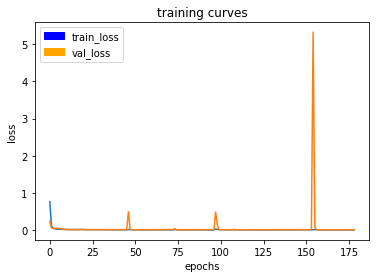

66/66 [==============================] - 119s - loss: 0.0077 - val_loss: 0.0120
Epoch 180/200
65/66 [============================>.] - ETA: 1s - loss: 0.0073

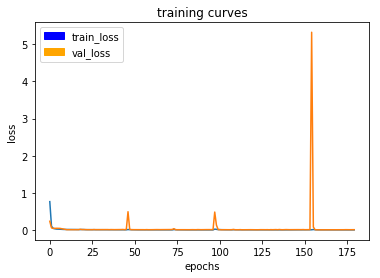

66/66 [==============================] - 120s - loss: 0.0073 - val_loss: 0.0135
Epoch 181/200
65/66 [============================>.] - ETA: 1s - loss: 0.0074

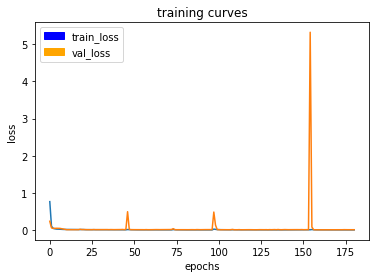

66/66 [==============================] - 119s - loss: 0.0074 - val_loss: 0.0125
Epoch 182/200
65/66 [============================>.] - ETA: 1s - loss: 0.0074

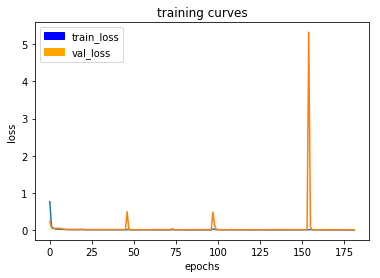

66/66 [==============================] - 119s - loss: 0.0074 - val_loss: 0.0134
Epoch 183/200
65/66 [============================>.] - ETA: 1s - loss: 0.0075

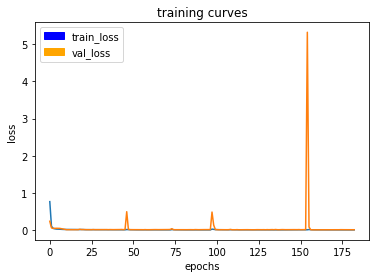

66/66 [==============================] - 119s - loss: 0.0074 - val_loss: 0.0121
Epoch 184/200
65/66 [============================>.] - ETA: 1s - loss: 0.0074

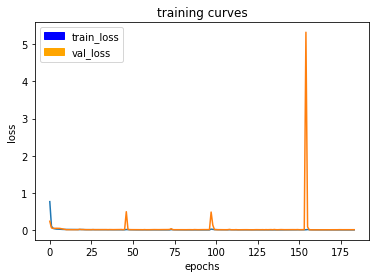

66/66 [==============================] - 119s - loss: 0.0073 - val_loss: 0.0133
Epoch 185/200
65/66 [============================>.] - ETA: 1s - loss: 0.0074

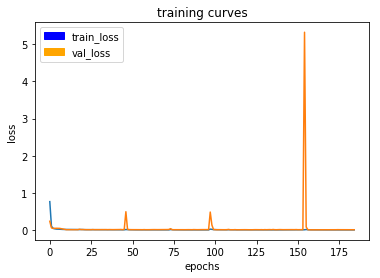

66/66 [==============================] - 119s - loss: 0.0074 - val_loss: 0.0121
Epoch 186/200
65/66 [============================>.] - ETA: 1s - loss: 0.0074

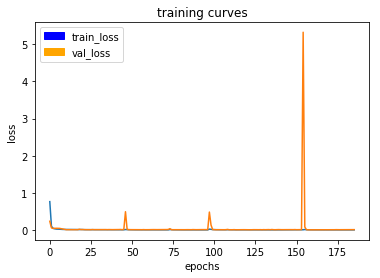

66/66 [==============================] - 119s - loss: 0.0074 - val_loss: 0.0148
Epoch 187/200
65/66 [============================>.] - ETA: 1s - loss: 0.0072

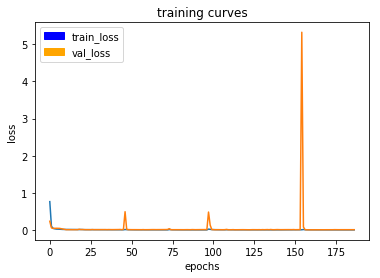

66/66 [==============================] - 119s - loss: 0.0072 - val_loss: 0.0132
Epoch 188/200
65/66 [============================>.] - ETA: 1s - loss: 0.0073

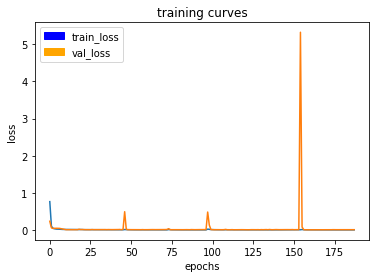

66/66 [==============================] - 118s - loss: 0.0073 - val_loss: 0.0133
Epoch 189/200
65/66 [============================>.] - ETA: 1s - loss: 0.0073

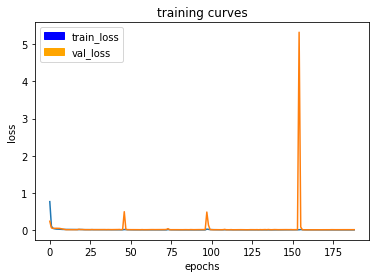

66/66 [==============================] - 119s - loss: 0.0074 - val_loss: 0.0135
Epoch 190/200
65/66 [============================>.] - ETA: 1s - loss: 0.0071

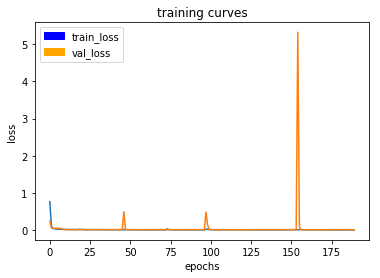

66/66 [==============================] - 118s - loss: 0.0071 - val_loss: 0.0137
Epoch 191/200
65/66 [============================>.] - ETA: 1s - loss: 0.0072

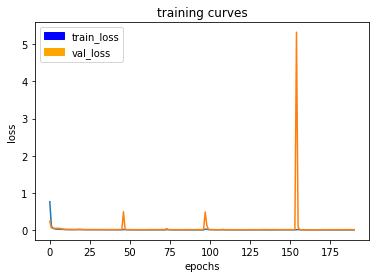

66/66 [==============================] - 120s - loss: 0.0072 - val_loss: 0.0146
Epoch 192/200
65/66 [============================>.] - ETA: 1s - loss: 0.0071

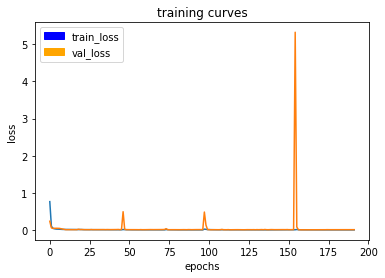

66/66 [==============================] - 118s - loss: 0.0071 - val_loss: 0.0137
Epoch 193/200
65/66 [============================>.] - ETA: 1s - loss: 0.0071

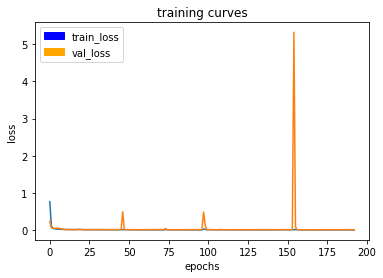

66/66 [==============================] - 119s - loss: 0.0071 - val_loss: 0.0131
Epoch 194/200
65/66 [============================>.] - ETA: 1s - loss: 0.0073

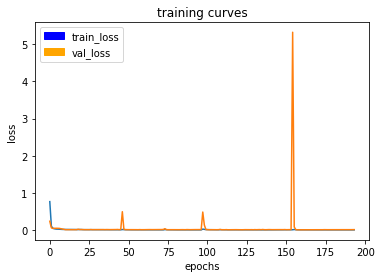

66/66 [==============================] - 119s - loss: 0.0073 - val_loss: 0.0150
Epoch 195/200
65/66 [============================>.] - ETA: 1s - loss: 0.0071

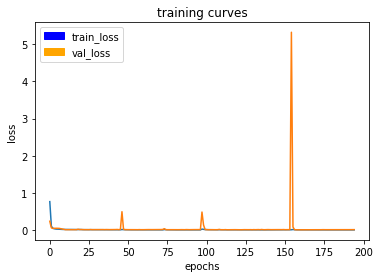

66/66 [==============================] - 119s - loss: 0.0071 - val_loss: 0.0146
Epoch 196/200
65/66 [============================>.] - ETA: 1s - loss: 0.0070

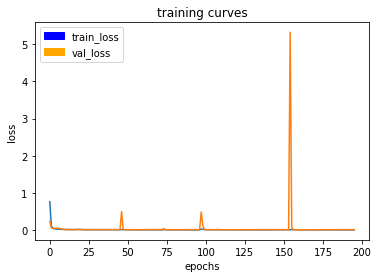

66/66 [==============================] - 118s - loss: 0.0070 - val_loss: 0.0138
Epoch 197/200
65/66 [============================>.] - ETA: 1s - loss: 0.0073

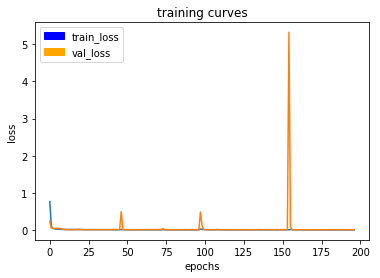

66/66 [==============================] - 119s - loss: 0.0073 - val_loss: 0.0135
Epoch 198/200
65/66 [============================>.] - ETA: 1s - loss: 0.0071

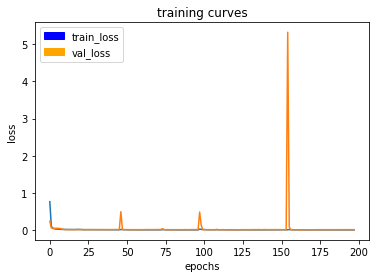

66/66 [==============================] - 118s - loss: 0.0071 - val_loss: 0.0135
Epoch 199/200
65/66 [============================>.] - ETA: 1s - loss: 0.0070

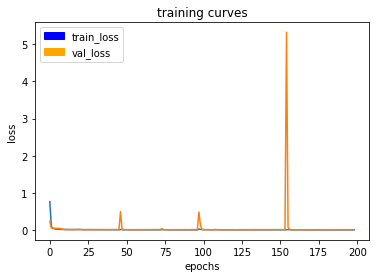

66/66 [==============================] - 119s - loss: 0.0070 - val_loss: 0.0140
Epoch 200/200
65/66 [============================>.] - ETA: 1s - loss: 0.0143

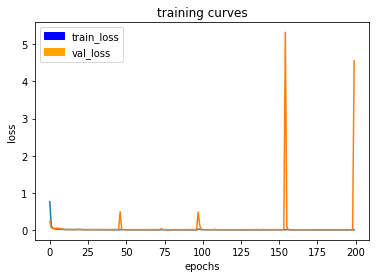

66/66 [==============================] - 119s - loss: 0.0145 - val_loss: 4.5531


In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [16]:
# Save your trained model weights
weight_file_name = 'model_weights_21'
model_tools.save_network(model, weight_file_name)

In [18]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.
#weight_file_name = 'model_weights_20'
#restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [19]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

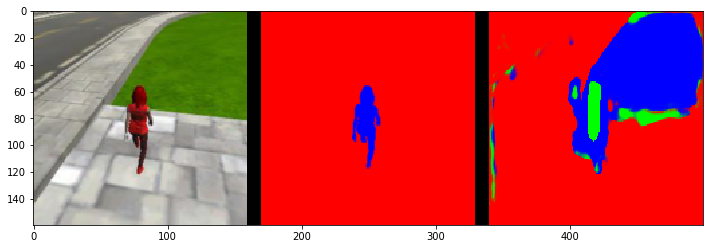

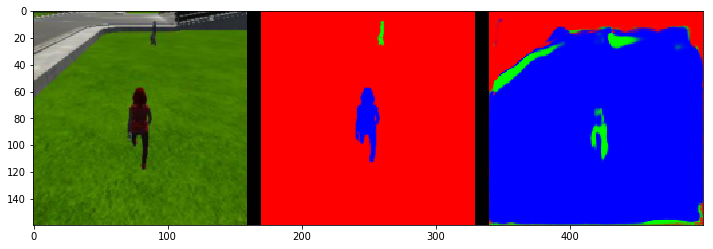

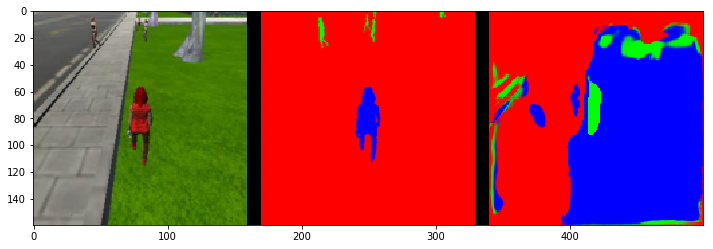

In [20]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

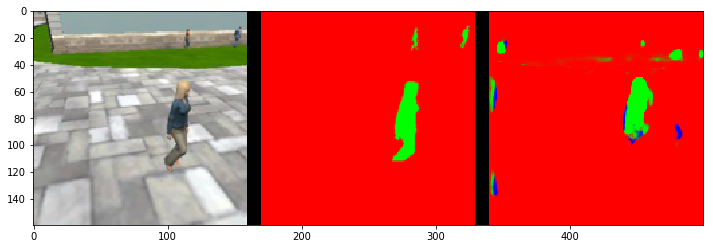

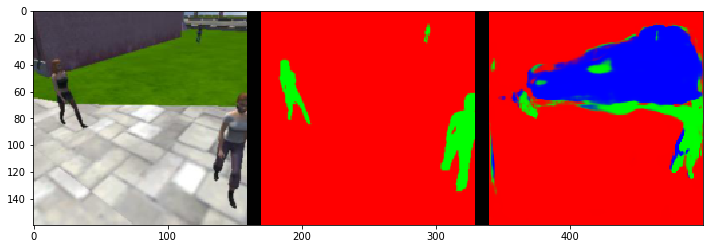

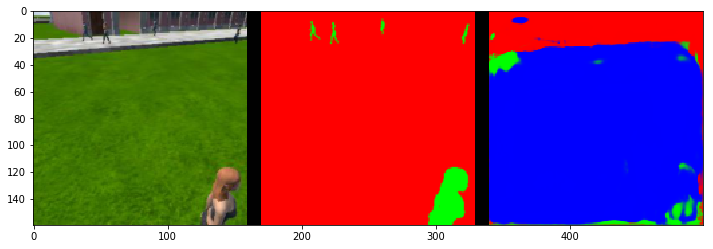

In [21]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

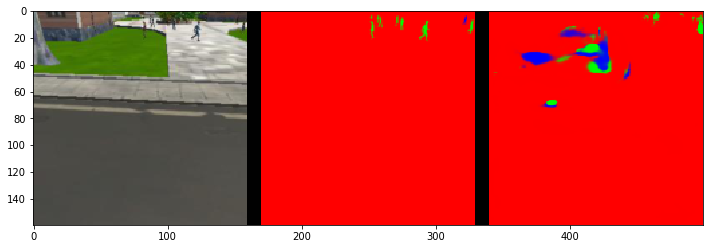

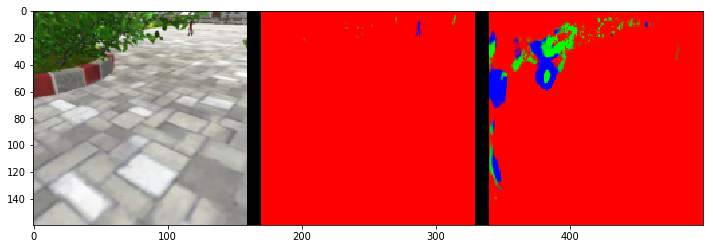

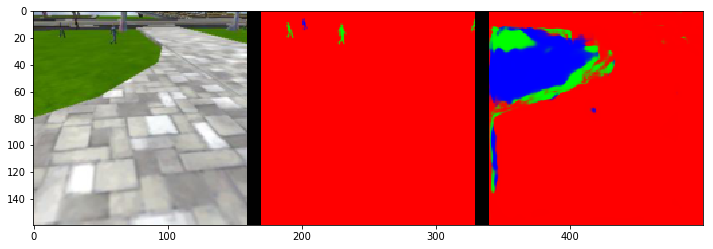

In [22]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [23]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.5342067823964555
average intersection over union for other people is 0.03718575529560487
average intersection over union for the hero is 0.07651497509339249
number true positives: 539, number false positives: 3, number false negatives: 0


In [24]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.7279251840571992
average intersection over union for other people is 0.25116299999967184
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 270, number false negatives: 0


In [25]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.7296210494117888
average intersection over union for other people is 0.06759589045956899
average intersection over union for the hero is 0.018546670868415573
number true positives: 301, number false positives: 21, number false negatives: 0


In [26]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7407407407407407


In [27]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.0475308229809


In [28]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.0352080170229
